In [0]:
# the notebook is run in several parts to free RAM memory 
# none of "del 'var'", "%reset_selective" and "gc.collect()" successfully cleared RAM

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install ta
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==2.1.0
!pip install --upgrade grpcio

In [0]:
%matplotlib inline
%load_ext tensorboard
# %tensorboard --logdir logs

In [0]:
APP_PATH = "/content/drive/My Drive/Programming/stock_predictions"

import sys
sys.path.append(APP_PATH)


import numpy as np
np.random.seed(123)
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# pd.options.display.max_rows = 200
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import pickle

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, concatenate

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.utils import plot_model


from stock_predictions.constants import *
from stock_predictions.plots import *
from stock_predictions.train_test_split import *
from stock_predictions.rnn import *
from stock_predictions.metrics import *
from libs.tech_indicators.tech_indicators import calculate_tech_indicators
from libs.time_series_transformer.pipeline import create_pipeline
from libs.autoencoder.autoencoder import *


In [0]:
tf.__version__

'2.1.0'

# Predicting Stock Prices Of NYSE and NASDQ Traded Common Stocks With RNNs
***
Author: Hristo T. Raykov

Email: hristocr@gmail.com


## Abstract
***

We used historical prices augmented with technical indicators of NYSE and NSDQ traded common stocks to predict future prices. We used hypothesis testing to determine time series stationarity and ACF/PACF for calculating optimal lag number. After cleaning, validating and preprocessing data we created several RNN models using LSTM - 2 with all stocks (one base and one deep) and 2 with single stock data. We used autoencoder for dimentionality reduction and feature decorrelation and embedding layer for categorical variables. Done optimizing of learning rate on base model. None of the models gave good results to be applicable in practice.

## 1. Introduction
***
We are going to model common stock prices traded on NYSE and NASQ. To train the models we will use historical daily prices. To augment daily price features we will extract some technical indicators from the time series and create additional features that are widely used in technical analysis for predicting asset prices. Create lags of time series data based on the optimal time steps number determined with ACF/PACF functions. For modeling the data will try several RNN architectures based on LSTM. We will use 'Embedding' layer for categorical variables and autoencoder for dimentionality reduction on numerical features. The goal is to achieve valid price predictions that can be used to make profitable trading decisions.

## 2. Previous Research
***

### 2.1 Theoretical Aspect

Theoretical aspect of analizing stock price movements include several main algorithms specialized in time series like ARIMA, GARCH, RNNs and their derivatives. 

[ARIMA](https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788) (autorgressive integrated moving average) is a linear model that makes detrending (integrated part) and takes into account both previous prices (autorgressive part) and estimated errors (moving average part). [GARCH](https://machinelearningmastery.com/develop-arch-and-garch-models-for-time-series-forecasting-in-python/) (generalized autorgressive conditional heteroskedasticity) is like ARIMA but take into account changing variations in different time steps (conditional heteroskedasticity part). These models are machine learning algorithms. 

In time series analysis it's important to determine if the series are [stationary](https://machinelearningmastery.com/time-series-data-stationary-python/) or non-stationary. Stationary time series have constant statistics (mean, variance) over different time steps. Based on the result of the stationarity test we will choose whether to use ACF or PACF. Stock price movements tend to be non-stationary in long term. [ACF/PACF](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/) are widely used in autorgressive models to determine the optimal lag number for time series analysis.

We will create some [technical indicators](https://www.visualcapitalist.com/12-types-technical-indicators-stocks/) from historical prices. Technical indicators are widely used in technical analysis for taking trading decisions. They can be classified in 4 main categories:
* Trend Indicators
* Momentum Indicators
* Volatility Indicators
* Volume Indicators

Each of them can be defiened as 'overlay' (data is plotted on the price graph) or 'oscilators' (taking values b/w min and max numbers).

In this research we will not explore ARIMA and GARCH and will focus on more 
complex deep learning with recurrent neural networks ([RNNs](https://medium.com/machine-learning-bites/deeplearning-series-sequence-models-7855babeb586)) witch take time into account. [LSTM](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) are one of the most complicated types of RNNS and are one of the most widely used for predicting stock prices. 

We will make dimentionality reduction with [autoencoder](https://machinelearningmastery.com/lstm-autoencoders/) on historical prices and their derivatives (technical indicators) as these features are highly correllated and such transformation will remove the correlation. Categorical features will preprocess with ['Embedding'](https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/) layer to transform them into numerical vector feature.



### 2.2 Practical Aspect

From practical point of view there are many researches trying to predict financial assets movements. This turns out to be very challinging job as financial markets depend on many factors and some of them can hardly be evaluated and quantified as how different people react to news etc. 

There are many kernels related to predicting stock prices in [kaggle.com](https://www.kaggle.com/) - [S&P 500 stock dataset](https://www.kaggle.com/camnugent/sandp500/kernels), [NYSE dataset](https://www.kaggle.com/dgawlik/nyse/kernels), [Huge Stock Market dataset](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/kernels), [Daily Historical Stock Prices (1970 - 2018) dataset](https://www.kaggle.com/ehallmar/daily-historical-stock-prices-1970-2018/kernels) (used in this research) etc. Unfortunately there are few (if any exist) that model not one but multiple stocks at once. Modeling one single stock have advantages - lower variation so the model can perform better but that leads to overfitting problem. Disadvantages of single stock modeling: 
* we have to train new model for every single stock we want to evaluate and there are a lot of stocks trading on different exchanges.
* not big dataset for a single stock witch maybe a problem in training NNs

Modeling many stocks at once give us better generalization and bigger dataset to train NNs but most likely worse performance because of the dissimilarities in different stock's data. I could't find any other results comparable to the current analysis.


## 3. Data Acquisition
***
We will use [S&P 500 stock dataset](https://www.kaggle.com/camnugent/sandp500/kernels) from [kaggle.com](https://www.kaggle.com/) to take historical adjusted prices of common stocks. The dataset is downloaded and saved in google drive as 2 csv files - historical_stocks.csv and historical_stock_prices.csv. historical_stocks.csv contains fundamental information about each stock ticker (total of 6460). historical_stock_prices.csv contains adjusted historical daily prices for each ticker a total of 20 973 889 samples (one-to-many relationship).


### 3.1 Stocks Fundamental Data

In [0]:
all_stocks = pd.read_csv(DATA_FILE_PATH + HIST_STOCKS_FILE_NAME)

In [0]:
all_stocks

,ticker,exchange,name,sector,industry
0,PIH,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS
1,PIHPP,NASDAQ,"1347 PROPERTY INSURANCE HOLDINGS, INC.",FINANCE,PROPERTY-CASUALTY INSURERS
2,TURN,NASDAQ,180 DEGREE CAPITAL CORP.,FINANCE,FINANCE/INVESTORS SERVICES
3,FLWS,NASDAQ,"1-800 FLOWERS.COM, INC.",CONSUMER SERVICES,OTHER SPECIALTY STORES
4,FCCY,NASDAQ,1ST CONSTITUTION BANCORP (NJ),FINANCE,SAVINGS INSTITUTIONS
...,...,...,...,...,...
6455,ZOES,NYSE,"ZOE&#39;S KITCHEN, INC.",CONSUMER SERVICES,RESTAURANTS
6456,ZTS,NYSE,ZOETIS INC.,HEALTH CARE,MAJOR PHARMACEUTICALS
6457,ZTO,NYSE,ZTO EXPRESS (CAYMAN) INC.,TRANSPORTATION,TRUCKING FREIGHT/COURIER SERVICES
6458,ZUO,NYSE,"ZUORA, INC.",TECHNOLOGY,COMPUTER SOFTWARE: PREPACKAGED SOFTWARE


As we can see there are different tickers with same company name that's because besides common stock ticker companies may have issued different kinds of debt and structured products. Let's remove assets different from common stocks like preferred stocks, baby bonds, CEFs and ETFs which sector column is "nan".

In [0]:
all_stocks = all_stocks.groupby([COMPANY_NAME_COL]).apply(lambda gr: gr.head(1)).reset_index(drop=True)
nan_rows = all_stocks[all_stocks.isnull().any(axis=1)]
all_stocks = all_stocks[~all_stocks[TICKER_COL].isin(nan_rows[TICKER_COL])]
print("Total common stocks after cleaning: {}".format(len(all_stocks)))

Total common stocks after cleaning: 4546


### 3.2 Stocks Historical Data


In [0]:
stocks = pd.read_csv(DATA_FILE_PATH + HIST_PRICES_FILE_NAME)

In [0]:
stocks

,ticker,open,close,adj_close,low,high,volume,date
0,AHH,11.50000,11.58000,8.49315,11.25000,11.68000,4633900,2013-05-08
1,AHH,11.66000,11.55000,8.47115,11.50000,11.66000,275800,2013-05-09
2,AHH,11.55000,11.60000,8.50782,11.50000,11.60000,277100,2013-05-10
3,AHH,11.63000,11.65000,8.54449,11.55000,11.65000,147400,2013-05-13
4,AHH,11.60000,11.53000,8.45648,11.50000,11.60000,184100,2013-05-14
...,...,...,...,...,...,...,...,...
20973884,NZF,14.60000,14.59000,14.59000,14.58000,14.62000,137500,2018-08-20
20973885,NZF,14.60000,14.58000,14.58000,14.57000,14.61000,151200,2018-08-21
20973886,NZF,14.58000,14.59000,14.59000,14.57000,14.63000,185400,2018-08-22
20973887,NZF,14.60000,14.57000,14.57000,14.57000,14.64000,135600,2018-08-23


There are total of 20 973 889 observations for all sectors. 

### 3.3 Time Series
Let's merge two datasets and create time series. We will drop 'nan' values if any. And parse date column.

In [0]:
stocks = pd.merge(all_stocks, stocks, how="left", left_on=TICKER_COL, right_on=TICKER_COL)
nan_rows = stocks[stocks.isnull().any(axis=1)]
stocks = stocks[~stocks[TICKER_COL].isin(nan_rows[TICKER_COL])]
stocks[DATE_COL] = stocks[DATE_COL].astype(np.datetime64)

In [0]:
stocks

,ticker,exchange,name,sector,industry,open,close,adj_close,low,high,volume,date
0,FLWS,NASDAQ,"1-800 FLOWERS.COM, INC.",CONSUMER SERVICES,OTHER SPECIALTY STORES,21.75000,18.18750,18.18750,17.87500,22.25000,9543400.00000,1999-08-03
1,FLWS,NASDAQ,"1-800 FLOWERS.COM, INC.",CONSUMER SERVICES,OTHER SPECIALTY STORES,18.93750,17.00000,17.00000,16.87500,20.50000,4731800.00000,1999-08-04
2,FLWS,NASDAQ,"1-800 FLOWERS.COM, INC.",CONSUMER SERVICES,OTHER SPECIALTY STORES,17.06250,16.00000,16.00000,13.50000,17.12500,2851900.00000,1999-08-05
3,FLWS,NASDAQ,"1-800 FLOWERS.COM, INC.",CONSUMER SERVICES,OTHER SPECIALTY STORES,16.00000,17.00000,17.00000,16.00000,17.75000,1411800.00000,1999-08-06
4,FLWS,NASDAQ,"1-800 FLOWERS.COM, INC.",CONSUMER SERVICES,OTHER SPECIALTY STORES,17.93750,16.00000,16.00000,15.87500,17.93750,583000.00000,1999-08-09
...,...,...,...,...,...,...,...,...,...,...,...,...
17963173,ZNGA,NASDAQ,ZYNGA INC.,TECHNOLOGY,EDP SERVICES,3.74000,3.74000,3.74000,3.68000,3.77000,5321500.00000,2018-08-20
17963174,ZNGA,NASDAQ,ZYNGA INC.,TECHNOLOGY,EDP SERVICES,3.73000,3.74000,3.74000,3.70000,3.80000,5305500.00000,2018-08-21
17963175,ZNGA,NASDAQ,ZYNGA INC.,TECHNOLOGY,EDP SERVICES,4.12000,4.03000,4.03000,4.01000,4.14000,37775000.00000,2018-08-22
17963176,ZNGA,NASDAQ,ZYNGA INC.,TECHNOLOGY,EDP SERVICES,4.05000,3.93000,3.93000,3.90000,4.06000,12136300.00000,2018-08-23


In [0]:
stocks.dtypes

ticker               object
exchange             object
name                 object
sector               object
industry             object
open                float64
close               float64
adj_close           float64
low                 float64
high                float64
volume              float64
date         datetime64[ns]
dtype: object

### 3.4 Stratifing By Trading Days Count

Now we have removed 'nan' values but for each ticker we have different count of trading days. Let's explore that. 

In [0]:
stocks.shape

(17963124, 12)

In [0]:
trading_days = stocks.groupby(TICKER_COL).agg(first_date=pd.NamedAgg(column=DATE_COL, aggfunc=np.min), 
                                  last_date=pd.NamedAgg(column=DATE_COL, aggfunc=np.max),
                                  trading_days_count=pd.NamedAgg(column=DATE_COL, aggfunc=len)).reset_index()
trading_days

,ticker,first_date,last_date,trading_days_count
0,A,1999-11-18,2018-08-24,4722
1,AA,1970-01-02,2018-08-24,12273
2,AABA,1996-04-12,2018-08-24,5632
3,AAC,2018-01-16,2018-08-24,155
4,AAL,2005-09-27,2018-08-24,3251
...,...,...,...,...
4487,ZTS,2013-02-01,2018-08-24,1402
4488,ZUMZ,2005-05-06,2018-08-24,3350
4489,ZUO,2018-04-12,2018-08-24,95
4490,ZYME,2017-04-28,2018-08-24,335


In [0]:
trading_days.describe(include="all").T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
ticker,4492,4492,ARCO,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first_date,4492,2779,1980-03-17 00:00:00,289,1970-01-02,2018-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last_date,4492,32,2018-08-24 00:00:00,4386,2018-05-29,2018-08-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trading_days_count,4492.00000,NaN,NaN,NaN,NaT,NaT,3998.91451,3056.87786,17.00000,1214.00000,3447.00000,6095.00000,12274.00000


In [0]:
print("Counts by last recorded trading date:")
print(trading_days["last_date"].value_counts().head())

Counts by last recorded trading date:
2018-08-24    4386
2018-08-23      26
2018-08-22      10
2018-08-21       6
2018-08-17       6
Name: last_date, dtype: int64


We will use data for the last 2 years.
As we see most of the stocks have historical data until '2018-08-24' so we drop all stocks with last recorded trading date before '2018-08-24'. We also remove tickers with first recorded trading date after 2 year period start date and all historical prices prior 2 year period start date.

In [0]:
stocks_to_rem = set()
END_DATE = np.datetime64('2018-08-24')
start_date = END_DATE - HIST_PERIOD_CALENDAR_DAYS 

stocks_to_rem.update(trading_days[trading_days["last_date"] < END_DATE][TICKER_COL])
stocks_to_rem.update(trading_days[trading_days["first_date"] > start_date][TICKER_COL])
stocks = stocks[~stocks[TICKER_COL].isin(stocks_to_rem)]
stocks = stocks[stocks[DATE_COL] >= start_date]

In [0]:
trading_days = stocks.groupby(TICKER_COL).agg(first_date=pd.NamedAgg(column=DATE_COL, aggfunc=np.min), 
                                  last_date=pd.NamedAgg(column=DATE_COL, aggfunc=np.max),
                                  trading_days_count=pd.NamedAgg(column=DATE_COL, aggfunc=len)).reset_index()
print("Counts by date:")
print(trading_days["first_date"].value_counts().head())
print()
print("Counts by trading days number:")
print(trading_days["trading_days_count"].value_counts().head())

Counts by date:
2016-08-24    3908
2016-08-25      26
2016-08-30      14
2016-08-26      13
2016-08-29       4
Name: first_date, dtype: int64

Counts by trading days number:
505    3487
504      91
503      33
501      25
502      22
Name: trading_days_count, dtype: int64


There is still tickers with different number of historical trading days this is due to missing whole observations for specific trading days in some of the stocks. Let's remove them.

In [0]:
stocks_to_rem = set()
period_start_date = trading_days["first_date"].value_counts().index[0]
period_trading_days = trading_days["trading_days_count"].value_counts().index[0]

stocks_to_rem.update(trading_days[trading_days["first_date"] != period_start_date][TICKER_COL])
stocks_to_rem.update(trading_days[trading_days["trading_days_count"] != period_trading_days][TICKER_COL])

stocks = stocks[~stocks[TICKER_COL].isin(stocks_to_rem)].reset_index(drop=True)


In [0]:
trading_days = stocks.groupby(TICKER_COL).agg(first_date=pd.NamedAgg(column=DATE_COL, aggfunc=np.min), 
                                  last_date=pd.NamedAgg(column=DATE_COL, aggfunc=np.max),
                                  trading_days_count=pd.NamedAgg(column=DATE_COL, aggfunc=len)).reset_index()
print(trading_days["first_date"].value_counts().head())
print()
print(trading_days["trading_days_count"].value_counts().head())


2016-08-24    3487
Name: first_date, dtype: int64

505    3487
Name: trading_days_count, dtype: int64


In [0]:
stocks.shape

(1760935, 12)

All looks good. Checking for 'nan' values.

In [0]:
nan_rows = stocks[stocks.isnull().any(axis=1)]
nan_rows

,ticker,exchange,name,sector,industry,open,close,adj_close,low,high,volume,date


## 4. EDA
***



In [0]:
stocks.dtypes

ticker               object
exchange             object
name                 object
sector               object
industry             object
open                float64
close               float64
adj_close           float64
low                 float64
high                float64
volume              float64
date         datetime64[ns]
dtype: object

In [0]:
stocks.shape

(1760935, 12)

In [0]:
print("Total stocks: {}".format(len(stocks[TICKER_COL].unique())))
print("Historical observations for each stock: {}".format(stocks[TICKER_COL].value_counts()[0]))

Total stocks: 3487
Historical observations for each stock: 505


So we have a dataset with 12 columns, 3487 unique stocks with 505 samples each and a total of 1 760 935 historical daily prices for the last 2 years. Let's look into features.

### 4.1 Exploring Numeric Features 

In [0]:
numeric_cols = [OPEN_PRICE_COL, CLOSE_PRICE_COL, ADJ_CLOSE_PRICE_COL, LOW_PRICE_COL, HIGH_PRICE_COL, VOLUME_COL]

In [0]:
stocks.describe(percentiles=[0.1,0.25,0.5,0.75,0.9], include=[np.number]).T

,count,mean,std,min,10%,25%,50%,75%,90%,max
open,1760935.00000,42.94070,76.78250,0.03000,3.78000,10.60000,25.37000,51.80000,92.00000,3698.85010
close,1760935.00000,42.94018,76.79757,0.03000,3.77000,10.60000,25.37000,51.80000,91.99000,3700.00000
adj_close,1760935.00000,42.29977,76.48266,0.00291,3.72000,10.40758,24.75000,50.88612,90.83516,3700.00000
low,1760935.00000,42.42498,75.98159,0.03000,3.67000,10.40000,25.05000,51.19140,91.01000,3627.97998
high,1760935.00000,43.44593,77.58428,0.03000,3.89000,10.81000,25.70000,52.40000,92.95000,3700.00000
volume,1760935.00000,1306726.97850,4057307.16386,100.00000,32200.00000,102100.00000,342200.00000,1067200.00000,2870400.00000,363256400.00000


We have valid values all are gretter than 0. Let's plot distributions.

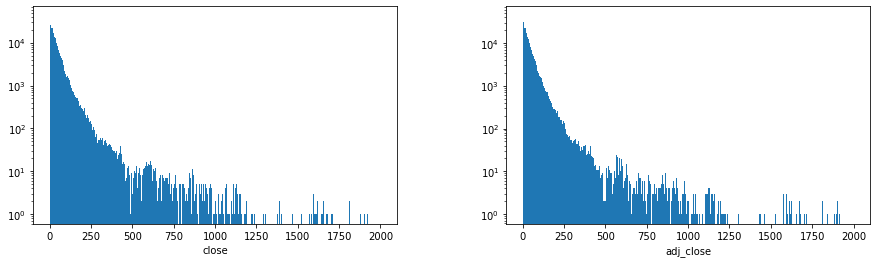

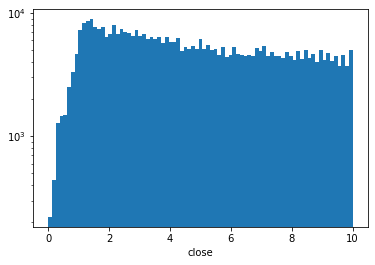

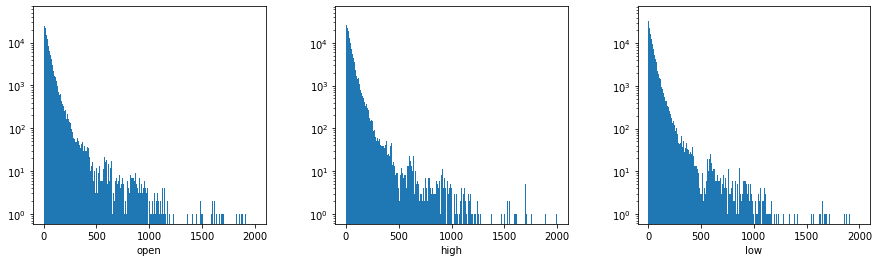

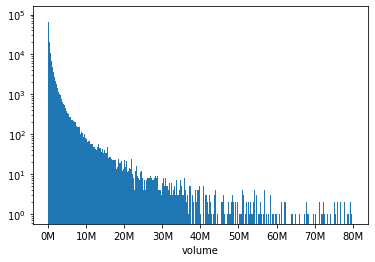

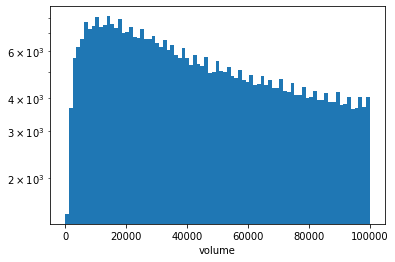

In [0]:
plot_dist_charts(stocks, [CLOSE_PRICE_COL, ADJ_CLOSE_PRICE_COL], bins="fd", range=(0,2000), log=True)

plt.hist(stocks[CLOSE_PRICE_COL], bins="fd", log=True, range=(0, 10))
plt.xlabel(CLOSE_PRICE_COL)
plt.show()

plot_dist_charts(stocks, [OPEN_PRICE_COL, HIGH_PRICE_COL, LOW_PRICE_COL], bins="fd", range=(0,2000), log=True)

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: "{:d}M".format(int(x/1000000))))
plt.hist(stocks[VOLUME_COL],  bins="fd", log=True, range=(0, 80000000))
plt.xlabel(VOLUME_COL)
plt.show()

plt.hist(stocks[VOLUME_COL],  bins="fd", log=True, range=(0, 100000))
plt.xlabel(VOLUME_COL)
plt.show()

Most prices are b/w 0 and \$1000. Stocks traded below \$5 traded on OTC markets are called penny stocks and are considered riskier. Although we analyse only NYSE and NSDQ traded stocks we will remove common stocks with prices less than \$5. We will also remove outliers with high prices over \$1000, average volume under 20k and over 40 millions.

In [0]:
stocks_to_rem = set()

min_stock_prices = stocks.groupby(TICKER_COL)[CLOSE_PRICE_COL].agg(min)
aver_stock_volume = stocks.groupby(TICKER_COL)[VOLUME_COL].mean()

stocks_to_rem.update(min_stock_prices[(min_stock_prices < 5) | (min_stock_prices > 1000)].index)
stocks_to_rem.update(aver_stock_volume[(aver_stock_volume < 20000) | (aver_stock_volume > 40000000)].index)

stocks = stocks[~stocks[TICKER_COL].isin(stocks_to_rem)]
print("Common stocks count: {}".format(len(stocks[TICKER_COL].unique())))

Common stocks count: 2661


After this we have 2661 unique stocks from 3487 before removing outliers. Lets explore correlations.

In [0]:
stocks.corr()

,open,close,adj_close,low,high,volume
open,1.00000,0.99979,0.99946,0.99987,0.99987,0.00545
close,0.99979,1.00000,0.99967,0.99988,0.99988,0.00534
adj_close,0.99946,0.99967,1.00000,0.99952,0.99957,0.00483
low,0.99987,0.99988,0.99952,1.00000,0.99976,0.00488
high,0.99987,0.99988,0.99957,0.99976,1.00000,0.00587
volume,0.00545,0.00534,0.00483,0.00488,0.00587,1.00000


As expected 'open', 'low', 'high', 'close' and "adj_close" have very high correlation. We will use autoencoder to remove that correlation.

### 4.2 Exploring Categorical Features 

In [0]:
stocks.describe(include=["O"]).T

,count,unique,top,freq
ticker,1343805,2661,RMD,505
exchange,1343805,2,NYSE,764570
name,1343805,2661,"HELMERICH & PAYNE, INC.",505
sector,1343805,12,CONSUMER SERVICES,251995
industry,1343805,134,MAJOR BANKS,93930


We have 12 sectors which are further branched out in 133 industries. Let's see categorical variables with bar charts.

In [0]:
categories = stocks.groupby(TICKER_COL).first()[[EXCHANGE_COL, SECTOR_COL, INDUSTRY_COL]]

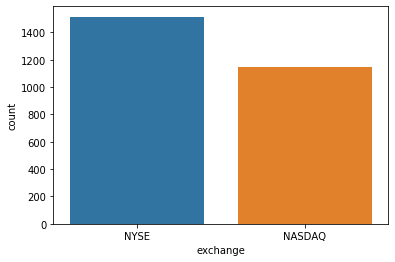

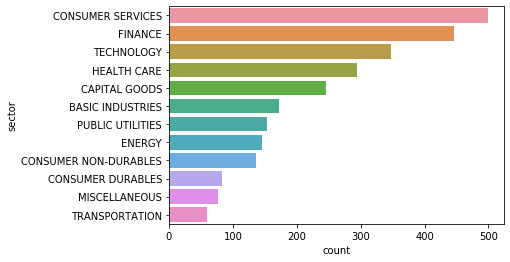

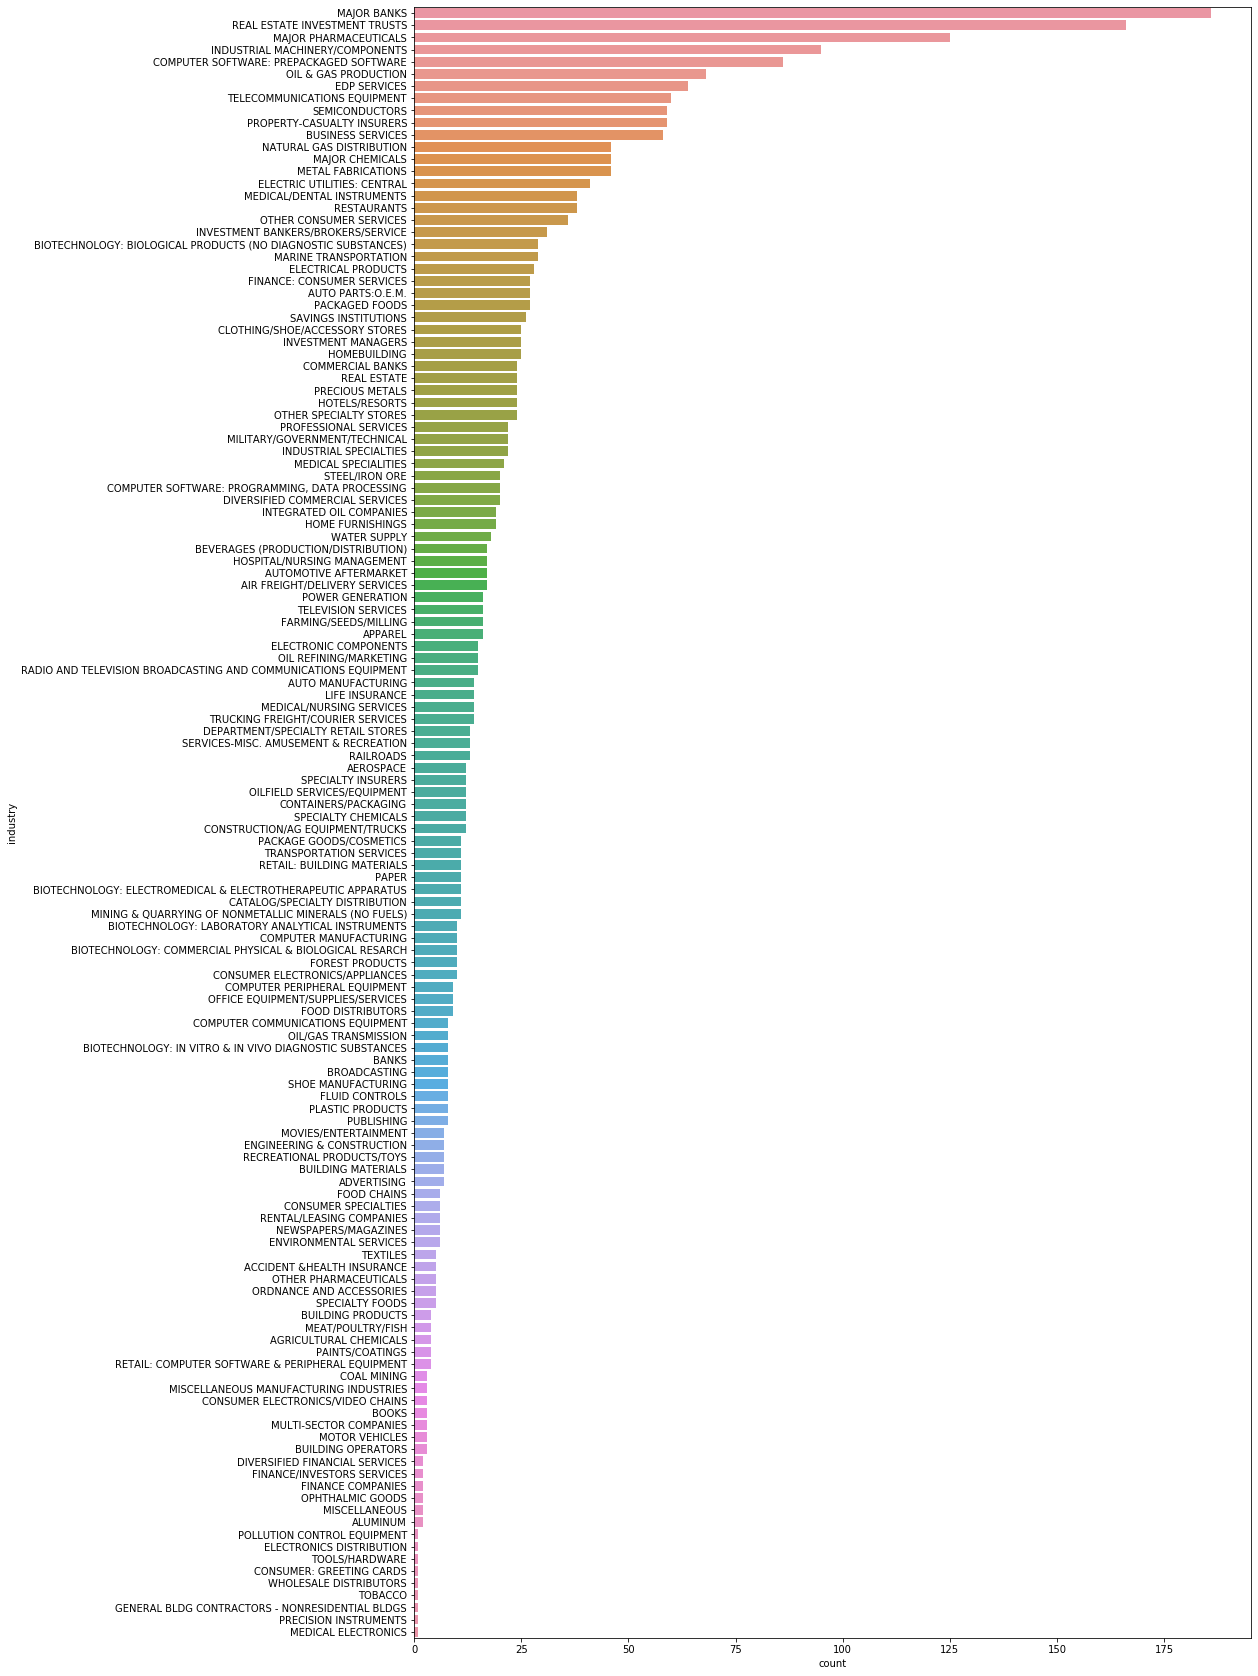

In [0]:
sns.countplot(x=categories[EXCHANGE_COL], order = categories[EXCHANGE_COL].value_counts().index)
plt.show()

sns.countplot(y=categories[SECTOR_COL], order = categories[SECTOR_COL].value_counts().index)
plt.show()

plt.figure(figsize=(15,30))
chart = sns.countplot(y=categories[INDUSTRY_COL], order = categories[INDUSTRY_COL].value_counts().index)
plt.show()

'Consumer Services', 'Finance' and 'Technology' are top 3 sectors by stocks count. Top 3 industries are 'Major Banks', 'Real Estate Investment Trusts' and 'Major Pharmaceuticals'.

### 4.3 Testing Time Series Stationarity

We will perform [Augmented Dickey–Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) on adjusted close prices of 3 different stocks to determine if data is stationary or not. Will use confidence level of 0.05.

* Null Hypothesis ($H_0$): Time series is non-stationary it is time dependent
* Alternate Hypothesis ($H_1$): Time series is stationary it is not time dependent
* $\alpha = 0,05$




In [0]:
sample_stocks = ["GOOG", "EBAY", "GS"]

In [0]:
for stock in sample_stocks:
  stock_prices = stocks[stocks[TICKER_COL]==stock][ADJ_CLOSE_PRICE_COL]
  results = adfuller(stock_prices.values)
  adf_statistic, p_value = results[0], results[1]
  print("Augmented Dickey–Fuller test for {}".format(stock))
  print("ADF statistic: {:.2f}".format(adf_statistic))
  print("p-value: {:.2f}".format(p_value))
  print()


Augmented Dickey–Fuller test for GOOG
ADF statistic: -0.63
p-value: 0.86

Augmented Dickey–Fuller test for EBAY
ADF statistic: -1.57
p-value: 0.50

Augmented Dickey–Fuller test for GS
ADF statistic: -2.59
p-value: 0.09



In all 3 cases p_value > $\alpha$ so we can not reject the null hypothesis $H_0$ and will consider time series as non-stationary.

### 4.3 Determing Optimal Lag Number With ACF/PACF


We will take 5 stocks and plot ACF and PACF on the adj_close data to see how lag prices correlate with most recent prices. We will look for where ACF/PACF graph crosses confidence level line (or 0) for first time after that point lag values are consider meaningless for predicting future prices because they don't correlate. ACF should be used for stationary time series that are detrended. PACF make correlations b/w residuals thus works fine on time series with trends. As we saw from Augmented Dickey-Fuller tests historical prices are non-stationary so we will focus on results from PACF.

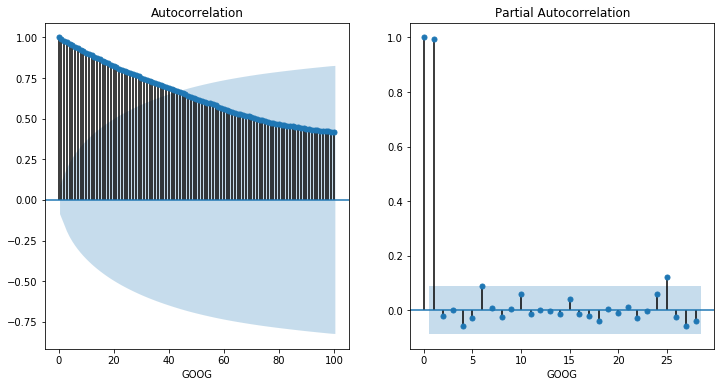

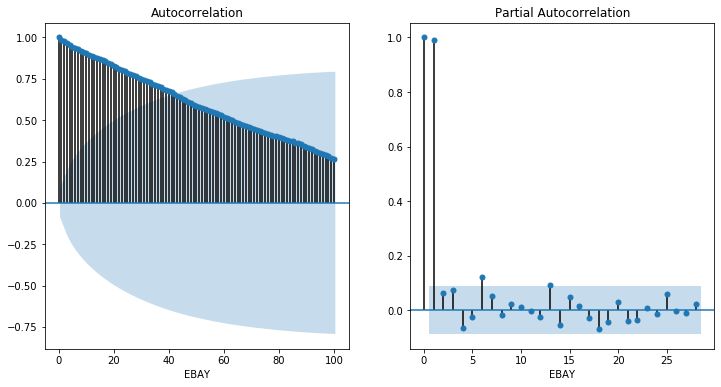

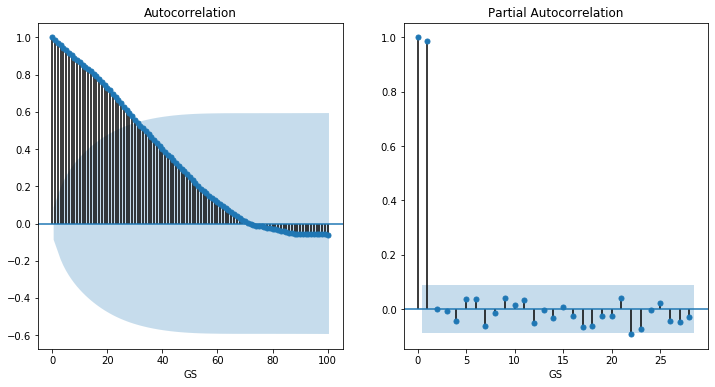

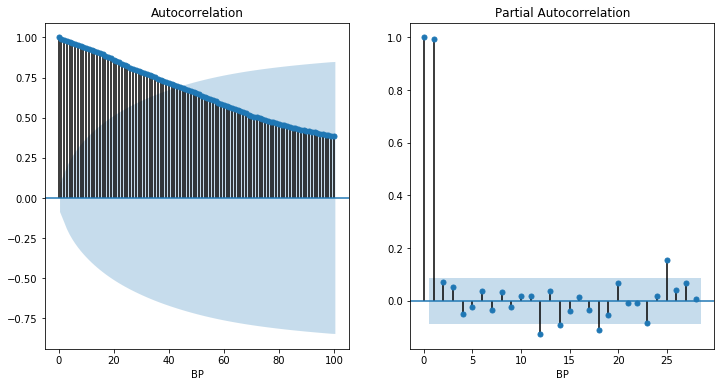

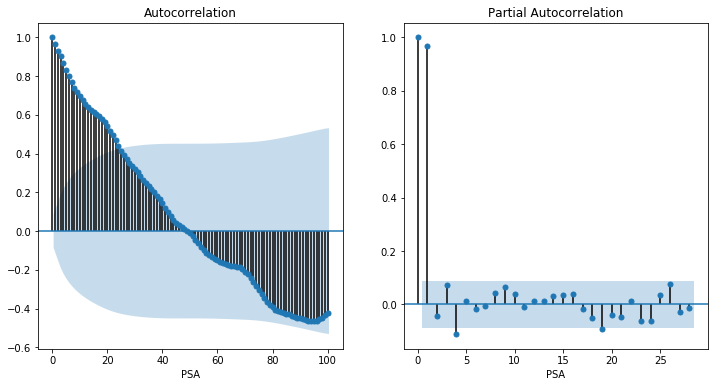

In [0]:
sample_stocks = ["GOOG", "EBAY", "GS", "BP", "PSA"]
plot_acf_pacf_by_tickers(stocks, column=ADJ_CLOSE_PRICE_COL, tickers=sample_stocks)

All ACF functions except 'PSA' cross confidence level at around 50th lag and 'PSA' at around 30th lag. All PACF have big drop in correlation after the first lag still there are some positive correlations till 4-5 lag. Based on that we will perform predictions creating 5 lags back in time. 

## 5. Feature Engineering
***

Let's see current columns.


In [0]:
stocks.columns

Index(['ticker', 'exchange', 'name', 'sector', 'industry', 'open', 'close',
       'adj_close', 'low', 'high', 'volume', 'date'],
      dtype='object')

We will calculate technical indicators used in technical analysis to augment current price features. For calculating them we need 'low', 'high', 'close' and 'volume' for each time step. Instead of 'close' prices we will use 'adj_close' prices which are adjusted for dividends and splits so ex-dividend day gaps are removed. As we use 'adj_close' we need to calculate also 'adj_low', 'adj_high' and 'adj_open' and from now on we will work with them.

In [0]:
price_adjustments = stocks[CLOSE_PRICE_COL] - stocks[ADJ_CLOSE_PRICE_COL]
stocks[ADJ_OPEN_PRICE_COL] = stocks[OPEN_PRICE_COL] - price_adjustments
stocks[ADJ_LOW_PRICE_COL] = stocks[LOW_PRICE_COL] - price_adjustments
stocks[ADJ_HIGH_PRICE_COL] = stocks[HIGH_PRICE_COL] - price_adjustments
stocks

,ticker,exchange,name,sector,industry,open,close,adj_close,low,high,volume,date,adj_open,adj_low,adj_high
0,FLWS,NASDAQ,"1-800 FLOWERS.COM, INC.",CONSUMER SERVICES,OTHER SPECIALTY STORES,9.55000,9.61000,9.61000,9.55000,9.86000,239400.00000,2016-08-24,9.55000,9.55000,9.86000
1,FLWS,NASDAQ,"1-800 FLOWERS.COM, INC.",CONSUMER SERVICES,OTHER SPECIALTY STORES,9.54000,9.33000,9.33000,8.80000,9.54000,667100.00000,2016-08-25,9.54000,8.80000,9.54000
2,FLWS,NASDAQ,"1-800 FLOWERS.COM, INC.",CONSUMER SERVICES,OTHER SPECIALTY STORES,9.36000,9.31000,9.31000,9.21000,9.45000,279500.00000,2016-08-26,9.36000,9.21000,9.45000
3,FLWS,NASDAQ,"1-800 FLOWERS.COM, INC.",CONSUMER SERVICES,OTHER SPECIALTY STORES,9.30000,9.27000,9.27000,9.13000,9.34000,281700.00000,2016-08-29,9.30000,9.13000,9.34000
4,FLWS,NASDAQ,"1-800 FLOWERS.COM, INC.",CONSUMER SERVICES,OTHER SPECIALTY STORES,9.29000,9.35000,9.35000,9.20000,9.35000,190000.00000,2016-08-30,9.29000,9.20000,9.35000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760425,ZYNE,NASDAQ,"ZYNERBA PHARMACEUTICALS, INC.",HEALTH CARE,MAJOR PHARMACEUTICALS,6.28000,6.13000,6.13000,6.01000,6.33900,309100.00000,2018-08-20,6.28000,6.01000,6.33900
1760426,ZYNE,NASDAQ,"ZYNERBA PHARMACEUTICALS, INC.",HEALTH CARE,MAJOR PHARMACEUTICALS,6.13000,6.31000,6.31000,6.07000,6.50000,589300.00000,2018-08-21,6.13000,6.07000,6.50000
1760427,ZYNE,NASDAQ,"ZYNERBA PHARMACEUTICALS, INC.",HEALTH CARE,MAJOR PHARMACEUTICALS,6.31000,6.26000,6.26000,6.23500,6.50000,263200.00000,2018-08-22,6.31000,6.23500,6.50000
1760428,ZYNE,NASDAQ,"ZYNERBA PHARMACEUTICALS, INC.",HEALTH CARE,MAJOR PHARMACEUTICALS,6.40000,6.30000,6.30000,6.16000,6.46000,325900.00000,2018-08-23,6.40000,6.16000,6.46000


We will create several indicators from each category (trend, momentum, volatility and volume). Creating indicators is done with custom library that wraps ['ta'](https://technical-analysis-library-in-python.readthedocs.io/en/latest/) library. 

In [0]:
stocks = stocks.sort_values([DATE_COL, TICKER_COL]).reset_index(drop=True)
stocks = stocks.groupby(TICKER_COL).apply(lambda gr: calculate_tech_indicators(gr, low_col=ADJ_LOW_PRICE_COL, high_col=ADJ_HIGH_PRICE_COL, close_col=ADJ_CLOSE_PRICE_COL, volume_col=VOLUME_COL))
stocks = stocks.dropna().reset_index(drop=True)

In [0]:
stocks

,ticker,exchange,name,sector,industry,open,close,adj_close,low,high,volume,date,adj_open,adj_low,adj_high,ema,macd,macd_diff,macd_signal,psar,psar_up_ind,psar_down_ind,cci,stoch_osc,stoch_osc_signal,rsi,roc,bb_ma,bb_hb,bb_hb_ind,bb_lb,bb_lb_ind,atr,std,cmf,obv,vwap
0,A,NYSE,"AGILENT TECHNOLOGIES, INC.",CAPITAL GOODS,BIOTECHNOLOGY: LABORATORY ANALYTICAL INSTRUMENTS,47.19000,45.69000,44.94201,45.42000,47.19000,2912500.00000,2016-10-11,46.44201,44.67201,46.44201,45.96210,0.18773,0.00540,0.18234,47.36927,0.00000,1.00000,-20.73146,10.01017,63.06340,42.39055,-4.19375,45.58296,47.35941,0.00000,43.80651,0.00000,0.80659,0.51462,0.08278,7842400.00000,45.53947
1,AABA,NASDAQ,ALTABA INC.,TECHNOLOGY,EDP SERVICES,43.87000,42.68000,42.68000,42.49000,44.08000,9513300.00000,2016-10-11,43.87000,42.49000,44.08000,43.28969,0.09913,-0.02849,0.12762,44.26821,0.00000,0.00000,-45.94269,27.48350,47.13028,46.22949,-2.82331,43.33650,44.37988,0.00000,42.29312,0.00000,0.84853,0.54190,-0.01937,52600200.00000,43.33478
2,AAL,NASDAQ,"AMERICAN AIRLINES GROUP, INC.",TRANSPORTATION,AIR FREIGHT/DELIVERY SERVICES,39.99000,38.20000,37.51964,38.06000,39.99000,10034700.00000,2016-10-11,39.30964,37.37964,39.30964,36.66919,0.44161,0.29656,0.14505,35.30078,0.00000,0.00000,142.41058,64.81545,80.60700,59.35415,-1.77424,35.83715,38.27961,0.00000,33.39469,0.00000,1.13224,1.26791,-0.18181,-30590300.00000,36.21700
3,AAN,NYSE,"AARON&#39;S, INC.",TECHNOLOGY,DIVERSIFIED COMMERCIAL SERVICES,24.04000,22.81000,22.68895,22.60000,24.55000,1693800.00000,2016-10-11,23.91895,22.47895,24.42895,24.72514,-0.13014,-0.12235,-0.00779,25.69926,0.00000,0.00000,-451.74346,6.39292,40.53590,31.55629,-10.96799,24.87379,26.00497,0.00000,23.74261,1.00000,0.76771,0.69562,-0.22608,358600.00000,24.68238
4,AAOI,NASDAQ,"APPLIED OPTOELECTRONICS, INC.",TECHNOLOGY,SEMICONDUCTORS,23.08000,22.04000,22.04000,21.82000,23.20000,358500.00000,2016-10-11,23.08000,21.82000,23.20000,21.93511,1.20033,-0.08189,1.28222,21.30919,0.00000,0.00000,64.75080,39.71835,56.52583,58.99659,-4.79481,21.79900,23.24324,0.00000,20.35476,0.00000,1.05005,0.87562,0.05056,7312700.00000,19.96725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255987,ZION,NASDAQ,ZIONS BANCORPORATION,FINANCE,MAJOR BANKS,53.81000,53.42000,53.42000,53.38000,53.93000,780900.00000,2018-08-24,53.81000,53.38000,53.93000,53.40426,0.22285,0.11061,0.11225,53.01000,0.00000,0.00000,64.58122,47.59779,58.15651,51.56082,-0.29863,53.11480,54.49205,0.00000,51.73755,0.00000,0.99093,0.57159,0.10284,216411100.00000,44.05849
1255988,ZOES,NYSE,"ZOE&#39;S KITCHEN, INC.",CONSUMER SERVICES,RESTAURANTS,13.41000,13.37000,13.37000,13.31000,13.43000,671000.00000,2018-08-24,13.41000,13.31000,13.43000,11.58438,0.88092,0.49239,0.38853,10.16475,0.00000,0.00000,119.89605,98.65901,98.53130,79.70534,-0.37258,10.42300,14.09189,0.00000,6.75411,0.00000,0.53686,2.11704,-0.28280,591200.00000,15.90016
1255989,ZTS,NYSE,ZOETIS INC.,HEALTH CARE,MAJOR PHARMACEUTICALS,89.82000,89.60000,89.60000,89.31000,90.20000,1655600.00000,2018-08-24,89.82000,89.31000,90.20000,90.48468,0.93282,-0.38366,1.31647,93.02697,0.00000,0.00000,-30.02094,9.95569,10.98814,50.16970,-0.07806,90.60650,95.21098,0.00000,86.00202,0.00000,1.48445,1.11815,0.09081,170855700.00000,64.53430
1255990,ZUMZ,NASDAQ,ZUMIEZ INC.,CONSUMER SERVICES,CLOTHING/SHOE/ACCESSORY STORES,30.00000,29.75000,29.75000,29.03000,30.15000,555300.00000,2018-08-24,30.00000,29.03000,30.15000,28.30181,1.71641,0.27871,1.43769,31.80000,0.00000,1.00000,73.38747,71.80193,76.17748,73.46584,-0.83333,26.89000,32.45297,0.00000,21.32703,0.00000,1.12378,1.65395,0.36205,27332900.00000,19.73663


## 6. Data Preprocessing
***
 After creating technical indicators let's see columns that we have. 

In [0]:
print(stocks.shape)
print(stocks.columns)

(1255992, 37)
Index(['ticker', 'exchange', 'name', 'sector', 'industry', 'open', 'close',
       'adj_close', 'low', 'high', 'volume', 'date', 'adj_open', 'adj_low',
       'adj_high', 'ema', 'macd', 'macd_diff', 'macd_signal', 'psar',
       'psar_up_ind', 'psar_down_ind', 'cci', 'stoch_osc', 'stoch_osc_signal',
       'rsi', 'roc', 'bb_ma', 'bb_hb', 'bb_hb_ind', 'bb_lb', 'bb_lb_ind',
       'atr', 'std', 'cmf', 'obv', 'vwap'],
      dtype='object')


As we say we will work with adjusted prices so can drop 'open', 'close', 'low', 'high' columns. We have 133 different industries to speed up training we will use only sector column which are 12 and gather all industries. Another columns that we can drop are 'exchange' and 'name' as they don't give us much information about the prices.

In [0]:
COLS_TO_DROP = [EXCHANGE_COL, COMPANY_NAME_COL, INDUSTRY_COL, OPEN_PRICE_COL, LOW_PRICE_COL, HIGH_PRICE_COL, CLOSE_PRICE_COL]
stocks = stocks.drop(COLS_TO_DROP, axis=1)

We will split categorical data ('sector' column) from numerical data as we will perform embedding on categorical data and input it separately to 'Embedding' layer then concatenate with price data. 

In [0]:
stocks_cats = stocks[[TICKER_COL, DATE_COL, SECTOR_COL]]
sector_enc = LabelEncoder()
stocks_cats[SECTOR_ENC_COL] = sector_enc.fit_transform(stocks_cats[[SECTOR_COL]].values)
stocks_cats = stocks_cats.set_index([TICKER_COL, DATE_COL, SECTOR_COL])

stocks = stocks.drop([SECTOR_COL], axis=1)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Most of the preprocessing is automated with sklearn transformers API. Custom classes that wrap the API are created and used in Pipeline so that several transformations are done one after another. The library can be found in project directory 'libs/time_series_transformer'. We will use function 'create_pipeline' that will make pipeline that create lags and prepare the data in format suitable for RNN with shape (samples, time_steps, features).

In [0]:
LAG_COLS = ['adj_close', 'volume', 'adj_open', 'adj_low',
            'adj_high', 'ema', 'macd', 'macd_diff', 'macd_signal', 'psar',
            'psar_up_ind', 'psar_down_ind', 'cci', 'stoch_osc', 'stoch_osc_signal',
            'rsi', 'roc', 'bb_ma', 'bb_hb', 'bb_hb_ind', 'bb_lb', 'bb_lb_ind',
            'atr', 'std', 'cmf', 'obv', 'vwap']
pipeline = create_pipeline(group_col=TICKER_COL, date_col=DATE_COL, target_col=ADJ_CLOSE_PRICE_COL,
                           create_lags=True, lag_cols=LAG_COLS, lag_num=TIME_STEPS, drop_lag_col=True,
                           trans_index=True,
                           time_step_trans=True)
stocks = pipeline.fit_transform(stocks)

pickle.dump(pipeline, open(PICKLE_FILE_PATH + PIPELINE_FILE_NAME, "wb"))


In [0]:
stocks

lag_0           lag_1  ...           lag_5           
                  adj_close adj_close_lag_1  ...       obv_lag_5 vwap_lag_5
ticker date                                  ...                           
A      2016-10-18  44.69610        44.41085  ...   7842400.00000   45.53947
AABA   2016-10-18  41.68000        41.79000  ...  52600200.00000   43.33478
AAL    2016-10-18  38.64915        37.89287  ... -30590300.00000   36.21700
AAN    2016-10-18  23.29571        22.69889  ...    358600.00000   24.68238
AAOI   2016-10-18  20.05000        20.03000  ...   7312700.00000   19.96725
...                     ...             ...  ...             ...        ...
ZION   2018-08-24  53.42000        53.58000  ... 215736800.00000   44.01417
ZOES   2018-08-24  13.37000        13.42000  ...  -1326300.00000   15.95468
ZTS    2018-08-24  89.60000        89.67000  ... 173487000.00000   64.37322
ZUMZ   2018-08-24  29.75000        30.00000  ...  26323900.00000   19.64871
ZYNE   2018-08-24   6.30000         6.30000  ... -10658200.00000   12.56746

[1242687 rows x 136 columns]

In [0]:
# dropping nans from lag creation 
period_start_date = stocks.index.get_level_values(1)[0]
stocks_cats = stocks_cats[stocks_cats.index.get_level_values(1) >= period_start_date]
stocks_cats

,,,sector_enc
ticker,date,sector,
A,2016-10-18,CAPITAL GOODS,1
AABA,2016-10-18,TECHNOLOGY,10
AAL,2016-10-18,TRANSPORTATION,11
AAN,2016-10-18,TECHNOLOGY,10
AAOI,2016-10-18,TECHNOLOGY,10
...,...,...,...
ZION,2018-08-24,FINANCE,6
ZOES,2018-08-24,CONSUMER SERVICES,4
ZTS,2018-08-24,HEALTH CARE,7


In [0]:
# restart and rerun notebook from next cell to free RAM 
stocks.to_csv(DATA_FILE_PATH + STOCKS_PRICES_FILE_NAME)
stocks_cats.to_csv(DATA_FILE_PATH + STOCKS_CATS_FILE_NAME)

Now lets separate training and testing datasets. We have 2661 different stocks with 467 historical time steps total of 1 242 687 observations. We will left aside about 10000 observations for testing dataset. As we work with time series that should be the latest time stpes. 5 time steps with 2661 stocks makes 13305 observations.

In [0]:
stocks_prices = pd.read_csv(DATA_FILE_PATH + STOCKS_PRICES_FILE_NAME, index_col=[0,1], header=[0,1])
stocks_cats = pd.read_csv(DATA_FILE_PATH + STOCKS_CATS_FILE_NAME, index_col=[0,1,2], header=[0])
# pipeline = pickle.load(open(PICKLE_FILE_PATH + PIPELINE_FILE_NAME, "rb"))

In [0]:
stocks_prices_train, stocks_prices_test = split_time_series_by_time_steps_index(stocks_prices, n_time_steps=TEST_TIME_STEPS_COUNT)

In [0]:
print(stocks_prices_train.shape)
print(stocks_prices_test.shape)

(1229382, 136)
(13305, 136)


We will create separate scalers for features and targets for convenience when evaluating errors. But first let's separate features and targets.

In [0]:
stocks_targets_train = stocks_prices_train[[("lag_0", ADJ_CLOSE_PRICE_COL)]]
stocks_prices_train = stocks_prices_train.drop([("lag_0", ADJ_CLOSE_PRICE_COL)], axis=1)

prices_scaler = MinMaxScaler()
targets_scaler = MinMaxScaler()

stocks_prices_train =  pd.DataFrame(prices_scaler.fit_transform(stocks_prices_train.values), columns=stocks_prices_train.columns, index=stocks_prices_train.index)
stocks_targets_train = pd.DataFrame(targets_scaler.fit_transform(stocks_targets_train.values), columns=stocks_targets_train.columns, index=stocks_targets_train.index)

pickle.dump(prices_scaler, open(PICKLE_FILE_PATH + PRICES_SCALER_FILE_NAME, "wb"))
pickle.dump(targets_scaler, open(PICKLE_FILE_PATH + TARGETS_SCALER_FILE_NAME, "wb"))

Separating validation data from the train dataset.

In [0]:
stocks_prices_train, stocks_prices_val = split_time_series_by_time_steps_index(stocks_prices_train, n_time_steps=TEST_TIME_STEPS_COUNT)
stocks_targets_train, stocks_targets_val = split_time_series_by_time_steps_index(stocks_targets_train, n_time_steps=TEST_TIME_STEPS_COUNT)

Preprocessing test dataset.

In [0]:
stocks_prices_test

lag_0           lag_1  ...           lag_5           
                  adj_close adj_close_lag_1  ...       obv_lag_5 vwap_lag_5
ticker date                                  ...                           
A      2018-08-20  64.47000        64.66000  ...  93279800.00000   59.23700
AABA   2018-08-20  69.26000        68.17000  ... 290351800.00000   58.32094
AAL    2018-08-20  39.99000        37.79000  ... -93046500.00000   44.83966
AAN    2018-08-20  49.47000        49.20000  ...  33731500.00000   37.37468
AAOI   2018-08-20  40.27000        40.16000  ...  59248800.00000   52.08998
...                     ...             ...  ...             ...        ...
ZION   2018-08-24  53.42000        53.58000  ... 215736800.00000   44.01417
ZOES   2018-08-24  13.37000        13.42000  ...  -1326300.00000   15.95468
ZTS    2018-08-24  89.60000        89.67000  ... 173487000.00000   64.37322
ZUMZ   2018-08-24  29.75000        30.00000  ...  26323900.00000   19.64871
ZYNE   2018-08-24   6.30000         6.30000  ... -10658200.00000   12.56746

[13305 rows x 136 columns]

In [0]:
stocks_targets_test = stocks_prices_test[[("lag_0", ADJ_CLOSE_PRICE_COL)]]
stocks_prices_test = stocks_prices_test.drop([("lag_0", ADJ_CLOSE_PRICE_COL)], axis=1)

stocks_prices_test = pd.DataFrame(prices_scaler.transform(stocks_prices_test.values), columns=stocks_prices_test.columns, index=stocks_prices_test.index)
stocks_targets_test = pd.DataFrame(targets_scaler.transform(stocks_targets_test.values), columns=stocks_targets_test.columns, index=stocks_targets_test.index)

Let's see what we have.

In [0]:
stocks_prices_train

lag_1               ...     lag_5           
                  adj_close_lag_1 volume_lag_1  ... obv_lag_5 vwap_lag_5
ticker date                                     ...                     
A      2016-10-18         0.02080      0.00431  ...   0.27992    0.03530
AABA   2016-10-18         0.01943      0.03200  ...   0.29490    0.03340
AAL    2016-10-18         0.01740      0.02080  ...   0.26705    0.02725
AAN    2016-10-18         0.00946      0.00137  ...   0.27741    0.01729
AAOI   2016-10-18         0.00807      0.00053  ...   0.27974    0.01322
...                           ...          ...  ...       ...        ...
ZION   2018-08-10         0.02521      0.00290  ...   0.35009    0.03388
ZOES   2018-08-10         0.00230      0.00252  ...   0.27098    0.01003
ZTS    2018-08-10         0.04586      0.00871  ...   0.33632    0.05120
ZUMZ   2018-08-10         0.01176      0.00388  ...   0.28451    0.01279
ZYNE   2018-08-10         0.00097      0.00115  ...   0.27319    0.00692

[1216077 rows x 135 columns]

In [0]:
stocks_targets_train

,,lag_0
,,adj_close
ticker,date,
A,2016-10-18,0.02095
AABA,2016-10-18,0.01937
AAL,2016-10-18,0.01779
AAN,2016-10-18,0.00977
AAOI,2016-10-18,0.00808
...,...,...
ZION,2018-08-10,0.02516
ZOES,2018-08-10,0.00217


Separating train, validation and test data from categorical dataset.

In [0]:
val_start_date = stocks_prices_val.index.get_level_values(DATE_COL)[0]
test_start_date = stocks_prices_test.index.get_level_values(DATE_COL)[0]

stocks_cats_train = stocks_cats[stocks_cats.index.get_level_values(DATE_COL) < val_start_date]
stocks_cats_val = stocks_cats[(stocks_cats.index.get_level_values(DATE_COL) >= val_start_date) & (stocks_cats.index.get_level_values(DATE_COL) < test_start_date)]
stocks_cats_test =  stocks_cats[stocks_cats.index.get_level_values(DATE_COL) >= test_start_date ]

In [0]:
stocks_cats_train

,,,sector_enc
ticker,date,sector,
A,2016-10-18,CAPITAL GOODS,1
AABA,2016-10-18,TECHNOLOGY,10
AAL,2016-10-18,TRANSPORTATION,11
AAN,2016-10-18,TECHNOLOGY,10
AAOI,2016-10-18,TECHNOLOGY,10
...,...,...,...
ZION,2018-08-10,FINANCE,6
ZOES,2018-08-10,CONSUMER SERVICES,4
ZTS,2018-08-10,HEALTH CARE,7


In [0]:
stocks_cats_val

,,,sector_enc
ticker,date,sector,
A,2018-08-13,CAPITAL GOODS,1
AABA,2018-08-13,TECHNOLOGY,10
AAL,2018-08-13,TRANSPORTATION,11
AAN,2018-08-13,TECHNOLOGY,10
AAOI,2018-08-13,TECHNOLOGY,10
...,...,...,...
ZION,2018-08-17,FINANCE,6
ZOES,2018-08-17,CONSUMER SERVICES,4
ZTS,2018-08-17,HEALTH CARE,7


In [0]:
stocks_cats_test

,,,sector_enc
ticker,date,sector,
A,2018-08-20,CAPITAL GOODS,1
AABA,2018-08-20,TECHNOLOGY,10
AAL,2018-08-20,TRANSPORTATION,11
AAN,2018-08-20,TECHNOLOGY,10
AAOI,2018-08-20,TECHNOLOGY,10
...,...,...,...
ZION,2018-08-24,FINANCE,6
ZOES,2018-08-24,CONSUMER SERVICES,4
ZTS,2018-08-24,HEALTH CARE,7


In [0]:
print("Prices train data shape: {}".format(stocks_prices_train.shape))
print("Categories train data shape: {}".format(stocks_cats_train.shape))
print("Targets train data shape: {}".format(stocks_targets_train.shape))

print("Prices val data shape: {}".format(stocks_prices_val.shape))
print("Categories val data shape: {}".format(stocks_cats_val.shape))
print("Targets val data shape: {}".format(stocks_targets_val.shape))

print("Prices test data shape: {}".format(stocks_prices_test.shape))
print("Categories test data shape: {}".format(stocks_cats_test.shape))
print("Targets test data shape: {}".format(stocks_targets_test.shape))

Prices train data shape: (1216077, 135)
Categories train data shape: (1216077, 1)
Targets train data shape: (1216077, 1)
Prices val data shape: (13305, 135)
Categories val data shape: (13305, 1)
Targets val data shape: (13305, 1)
Prices test data shape: (13305, 135)
Categories test data shape: (13305, 1)
Targets test data shape: (13305, 1)


Saving datasets.

In [0]:
stocks_prices_train.to_csv(DATA_FILE_PATH + TRAIN_DATA_DIR + PRICES_TRAIN_DATASET_FILENAME)
stocks_cats_train.to_csv(DATA_FILE_PATH + TRAIN_DATA_DIR + CATS_TRAIN_DATASET_FILENAME)
stocks_targets_train.to_csv(DATA_FILE_PATH + TRAIN_DATA_DIR + TARGETS_TRAIN_DATASET_FILENAME)

stocks_prices_val.to_csv(DATA_FILE_PATH + VAL_DATA_DIR + PRICES_VALIDATION_DATASET_FILENAME)
stocks_cats_val.to_csv(DATA_FILE_PATH + VAL_DATA_DIR + CATS_VALIDATION_DATASET_FILENAME)
stocks_targets_val.to_csv(DATA_FILE_PATH + VAL_DATA_DIR + TARGETS_VALIDATION_DATASET_FILENAME)

stocks_prices_test.to_csv(DATA_FILE_PATH + TEST_DATA_DIR + PRICES_TEST_DATASET_FILENAME)
stocks_cats_test.to_csv(DATA_FILE_PATH + TEST_DATA_DIR + CATS_TEST_DATASET_FILENAME)
stocks_targets_test.to_csv(DATA_FILE_PATH + TEST_DATA_DIR + TARGETS_TEST_DATASET_FILENAME)

## 7. Modeling Stocks Time Series With LSTM
***


### 7.1 Dimentionality Reduction With Autoencoder

#### 7.1.1 Preparing Autoencoder Model Dataset

We will wrap further pd.Dataframe datasets with tf.data.Dataset as tensorflow dataset allow batching so that parts of the dataset are feeded to GPU memory.

We will train autoencoder for stocks numerical features dimentionality reduction. This will remove correlation b/w features as many of them have very high correlation. We will use train and validation datasets for training autoencoder and test dataset for validation - not going to use test dataset here. 

In [0]:
stocks_prices_train = pd.read_csv(DATA_FILE_PATH + TRAIN_DATA_DIR + PRICES_TRAIN_DATASET_FILENAME, index_col=[0,1], header=[0,1])
stocks_targets_train = pd.read_csv(DATA_FILE_PATH +  TRAIN_DATA_DIR + TARGETS_TRAIN_DATASET_FILENAME, index_col=[0,1], header=[0,1])

stocks_prices_val = pd.read_csv(DATA_FILE_PATH + VAL_DATA_DIR + PRICES_VALIDATION_DATASET_FILENAME, index_col=[0,1], header=[0,1])
stocks_targets_val = pd.read_csv(DATA_FILE_PATH + VAL_DATA_DIR + TARGETS_VALIDATION_DATASET_FILENAME, index_col=[0,1], header=[0,1])

stocks_prices_test = pd.read_csv(DATA_FILE_PATH + TEST_DATA_DIR + PRICES_TEST_DATASET_FILENAME, index_col=[0,1], header=[0,1])
stocks_targets_test = pd.read_csv(DATA_FILE_PATH + TEST_DATA_DIR + TARGETS_TEST_DATASET_FILENAME, index_col=[0,1], header=[0,1])

In [0]:
stock_prices_autoenc_train = pd.concat([stocks_prices_train, stocks_prices_val])

In [0]:
num_fetures_count = stocks_prices_train["lag_1"].shape[1] # 27
batch_size = len(stocks_prices_train.index.get_level_values(TICKER_COL).unique())

In [0]:
stocks_autoenc_train = tf.data.Dataset.from_tensor_slices((stock_prices_autoenc_train.values.reshape((stock_prices_autoenc_train.values.shape[0], TIME_STEPS,num_fetures_count)), (stock_prices_autoenc_train.values.reshape((stock_prices_autoenc_train.values.shape[0], TIME_STEPS,num_fetures_count)))))
stocks_autoenc_train = stocks_autoenc_train.batch(batch_size, drop_remainder=True)
stocks_autoenc_val = tf.data.Dataset.from_tensor_slices((stocks_prices_test.values.reshape((stocks_prices_test.values.shape[0], TIME_STEPS,num_fetures_count)), (stocks_prices_test.values.reshape((stocks_prices_test.values.shape[0], TIME_STEPS,num_fetures_count)))))
stocks_autoenc_val = stocks_autoenc_val.batch(batch_size, drop_remainder=True)

In [0]:
stocks_autoenc_train

<BatchDataset shapes: ((2661, 5, 27), (2661, 5, 27)), types: (tf.float64, tf.float64)>

In [0]:
stocks_autoenc_val

<BatchDataset shapes: ((2661, 5, 27), (2661, 5, 27)), types: (tf.float64, tf.float64)>

#### 7.1.2 Building Autoencoder Model

We will use stacked LSTM autoencoder with two layers - 64 units in first layer and 32 units in second. Input features are 27 and we want to represent them in 8 dimentional space.

In [0]:
encoder_layer_1 = LSTM(units=ENC_LAYER_1_UNITS, return_sequences=True, stateful=True, name="enc_layer_1")
encoder_layer_2 = LSTM(units=ENC_LAYER_2_UNITS, return_sequences=True, stateful=True, name="enc_layer_2")
repres_layer = LSTM(units=REPRES_DIM, return_sequences=True, stateful=True, name="enc_repres_layer")

decoder_layer_1 = LSTM(units=ENC_LAYER_2_UNITS, return_sequences=True, stateful=True, name="dec_layer_1")
decoder_layer_2 = LSTM(units=ENC_LAYER_1_UNITS, return_sequences=True, stateful=True, name="dec_layer_2")
dec_output_layer = LSTM(units=num_fetures_count, return_sequences=True, stateful=True, name="dec_output_layer")

In [0]:
enc_inputs = Input(shape=(TIME_STEPS, num_fetures_count), batch_size=batch_size, name="encoder_inputs")
encoded = encoder_layer_1(enc_inputs)
encoded = encoder_layer_2(encoded)
enc_repres_output = repres_layer(encoded)

decoded = decoder_layer_1(enc_repres_output)
decoded = decoder_layer_2(decoded)
dec_outputs = dec_output_layer(decoded)

In [0]:
autoencoder = Model(inputs=enc_inputs, outputs=dec_outputs, name="lstm_autoencoder")

In [0]:
autoencoder.summary()

Model: "lstm_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(2661, 5, 27)]           0         
_________________________________________________________________
enc_layer_1 (LSTM)           (2661, 5, 64)             23552     
_________________________________________________________________
enc_layer_2 (LSTM)           (2661, 5, 32)             12416     
_________________________________________________________________
enc_repres_layer (LSTM)      (2661, 5, 8)              1312      
_________________________________________________________________
dec_layer_1 (LSTM)           (2661, 5, 32)             5248      
_________________________________________________________________
dec_layer_2 (LSTM)           (2661, 5, 64)             24832     
_________________________________________________________________
dec_output_layer (LSTM)      (2661, 5, 27)        

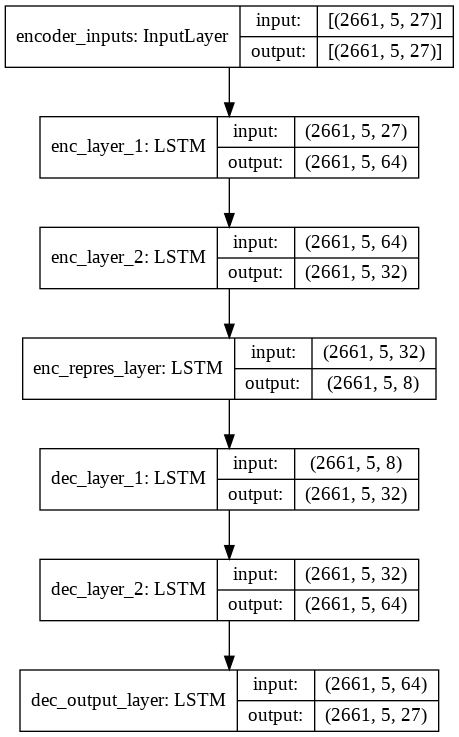

In [0]:
autoencoder_graph = plot_model(autoencoder, show_shapes=True, expand_nested=True)
autoencoder_graph

#### 7.1.3 Training Autoencoder Model

We will use 'adam' optimizer, MSE as loss function and RMSE as a metric.

In [0]:
targets_scaler = pickle.load(open(PICKLE_FILE_PATH + TARGETS_SCALER_FILE_NAME, "rb"))

In [0]:
autoencoder.compile(optimizer=Adam(), loss=tf.keras.losses.MSE, metrics = [RootMeanSquaredError()])

In [0]:
autoenc_tbc = TensorBoard(log_dir=AUTOENC_TBC_PATH)
steps_per_epoch=int(len(stock_prices_autoenc_train) / batch_size)

In [0]:
autoencoder, autoenc_hist = training_stateful_rnn(autoencoder, stocks_autoenc_train, init_epoch=0, epochs=300, steps_per_epoch=steps_per_epoch, val_data=stocks_autoenc_val, callbacks=[autoenc_tbc])

Train for 462 steps, validate for 5 steps
462/462 [==============================] - 25s 55ms/step - loss: 0.0175 - root_mean_squared_error: 0.1321 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1056
Train for 462 steps, validate for 5 steps
Epoch 2/2
462/462 [==============================] - 12s 26ms/step - loss: 0.0101 - root_mean_squared_error: 0.1004 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0679
Train for 462 steps, validate for 5 steps
Epoch 3/3
462/462 [==============================] - 12s 26ms/step - loss: 0.0044 - root_mean_squared_error: 0.0666 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0541
Train for 462 steps, validate for 5 steps
Epoch 4/4
462/462 [==============================] - 12s 27ms/step - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0456
Train for 462 steps, validate for 5 steps
Epoch 5/5
462/462 [==============================] - 12s 26ms/step - loss: 0.0020 - root_mean_squared_error:

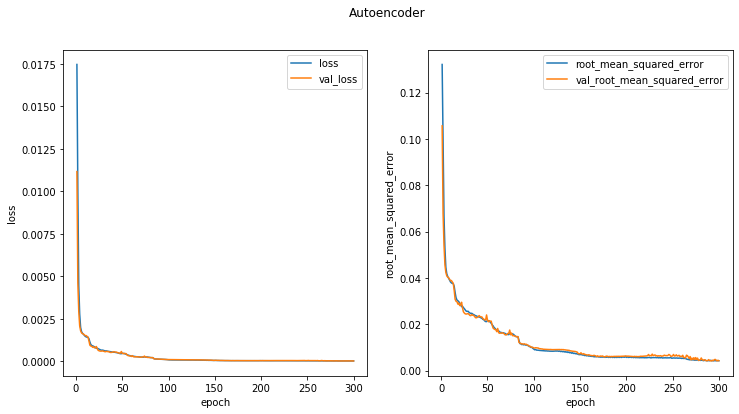

In [0]:
plot_model_history(autoenc_hist, fig_title="Autoencoder")

In [0]:
autoencoder.save(AUTOENC_SAVE_PATH, save_format="h5")
pickle.dump(autoenc_hist, open(AUTOENC_HISTORY_PATH, "wb"))

In [0]:
%tensorboard --logdir '/content/drive/My Drive/Programming/stock_predictions/models/num_autoenc/tbc/'

Saving encoder model.

In [0]:
encoder_outputs = autoencoder.get_layer("enc_repres_layer").output
encoder = Model(inputs=enc_inputs, outputs=encoder_outputs, name="lstm_encoder")
encoder.trainable = False

In [0]:
encoder.summary()

Model: "lstm_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(2661, 5, 27)]           0         
_________________________________________________________________
enc_layer_1 (LSTM)           (2661, 5, 64)             23552     
_________________________________________________________________
enc_layer_2 (LSTM)           (2661, 5, 32)             12416     
_________________________________________________________________
enc_repres_layer (LSTM)      (2661, 5, 8)              1312      
Total params: 37,280
Trainable params: 0
Non-trainable params: 37,280
_________________________________________________________________


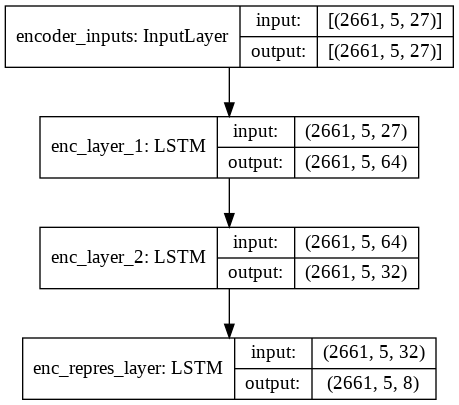

In [0]:
encoder_graph = plot_model(encoder, show_shapes=True, expand_nested=True)
encoder_graph

In [0]:
encoder.save(ENCODER_SAVE_PATH, save_format="h5")

### 7.2 Embedding Model

#### 7.2.1 Preparing RNN Model Dataset

We will create nested dataset consisting of stocks price features and stocks categorical features (label encoded) as input and stocks target prices as output. Shapes of the inputs should be (None, 5 time steps, 27 num features) for numerical inputs and (None, 1) for categorical inputs ('sector'). 

In [0]:
stocks_prices_train = pd.read_csv(DATA_FILE_PATH + TRAIN_DATA_DIR + PRICES_TRAIN_DATASET_FILENAME, index_col=[0,1], header=[0,1])
stocks_cats_train = pd.read_csv(DATA_FILE_PATH + TRAIN_DATA_DIR + CATS_TRAIN_DATASET_FILENAME, index_col=[0,1,2], header=[0])
stocks_targets_train = pd.read_csv(DATA_FILE_PATH +  TRAIN_DATA_DIR + TARGETS_TRAIN_DATASET_FILENAME, index_col=[0,1], header=[0,1])

stocks_prices_val = pd.read_csv(DATA_FILE_PATH + VAL_DATA_DIR + PRICES_VALIDATION_DATASET_FILENAME, index_col=[0,1], header=[0,1])
stocks_cats_val = pd.read_csv(DATA_FILE_PATH + VAL_DATA_DIR + CATS_VALIDATION_DATASET_FILENAME, index_col=[0,1,2], header=[0])
stocks_targets_val = pd.read_csv(DATA_FILE_PATH + VAL_DATA_DIR + TARGETS_VALIDATION_DATASET_FILENAME, index_col=[0,1], header=[0,1])

stocks_prices_test = pd.read_csv(DATA_FILE_PATH + TEST_DATA_DIR + PRICES_TEST_DATASET_FILENAME, index_col=[0,1], header=[0,1])
stocks_cats_test = pd.read_csv(DATA_FILE_PATH + TEST_DATA_DIR + CATS_TEST_DATASET_FILENAME, index_col=[0,1,2], header=[0])
stocks_targets_test = pd.read_csv(DATA_FILE_PATH + TEST_DATA_DIR + TARGETS_TEST_DATASET_FILENAME, index_col=[0,1], header=[0,1])

In [0]:
num_fetures_count = stocks_prices_train["lag_1"].shape[1] # 27
batch_size = len(stocks_prices_train.index.get_level_values(TICKER_COL).unique())

In [0]:
stocks_train = tf.data.Dataset.from_tensor_slices(((stocks_prices_train.values.reshape((stocks_prices_train.values.shape[0], TIME_STEPS,num_fetures_count)), stocks_cats_train.values), stocks_targets_train.values))
stocks_train = stocks_train.batch(batch_size)

In [0]:
stocks_train

<BatchDataset shapes: (((None, 5, 27), (None, 1)), (None, 1)), types: ((tf.float64, tf.int64), tf.float64)>

In [0]:
stocks_val = tf.data.Dataset.from_tensor_slices(((stocks_prices_val.values.reshape((stocks_prices_val.values.shape[0], TIME_STEPS,num_fetures_count)), stocks_cats_val.values), stocks_targets_val.values))
stocks_val = stocks_val.batch(batch_size)

In [0]:
stocks_val

<BatchDataset shapes: (((None, 5, 27), (None, 1)), (None, 1)), types: ((tf.float64, tf.int64), tf.float64)>

In [0]:
stocks_test = tf.data.Dataset.from_tensor_slices(((stocks_prices_test.values.reshape((stocks_prices_test.values.shape[0], TIME_STEPS,num_fetures_count)), stocks_cats_test.values), stocks_targets_test.values))
stocks_test = stocks_test.batch(batch_size)

In [0]:
stocks_test

<BatchDataset shapes: (((None, 5, 27), (None, 1)), (None, 1)), types: ((tf.float64, tf.int64), tf.float64)>

#### 7.2.2 Building Embedding Model

We will build embedding model that combines outputs from encoder for numerical features and embedding layer for categorical features into one feature vector that will be further feeded to LSTM layers.

In [0]:
encoder = load_model(ENCODER_SAVE_PATH)

In [0]:
EMBEDDED_VECTOR_SIZE = 4
categories_in_class = 12 # len(stocks_cats_train["sector_enc"].unique())

In [0]:
cats_inputs = Input(shape=(1, ), name="categories_inputs")
cats_embeds = Embedding(input_dim=categories_in_class, output_dim=EMBEDDED_VECTOR_SIZE, name="categories_embeddings")(cats_inputs) # , input_length=1
repeat_embeds = concatenate(TIME_STEPS*[cats_embeds], axis=1, name="repeat_categories_embeddings")

concat = concatenate([encoder.output, repeat_embeds], axis=2, name="concatenate_prices_cat_embeddings") # prices_inputs

In [0]:
inputs = [encoder.input, cats_inputs]
embed_model = Model(inputs=inputs, outputs=concat, name="embedding_model")

In [0]:
embed_model.summary()

Model: "embedding_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(2661, 5, 27)]      0                                            
__________________________________________________________________________________________________
enc_layer_1 (LSTM)              (2661, 5, 64)        23552       encoder_inputs[0][0]             
__________________________________________________________________________________________________
categories_inputs (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
enc_layer_2 (LSTM)              (2661, 5, 32)        12416       enc_layer_1[0][0]                
____________________________________________________________________________________

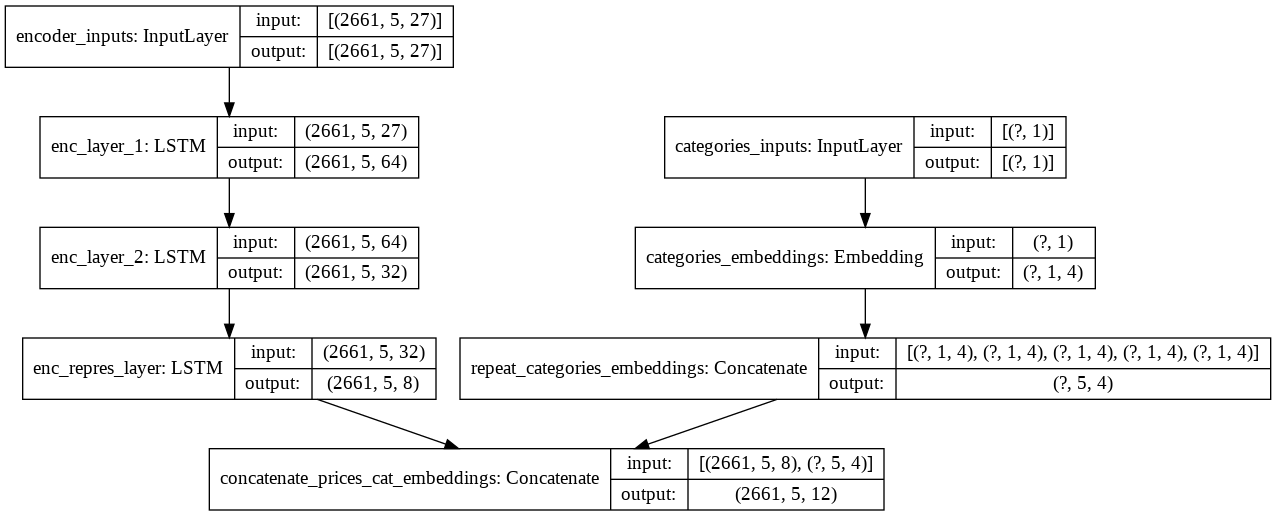

In [0]:
embed_model_graph = plot_model(embed_model,show_shapes=True, expand_nested=True)
embed_model_graph

In [0]:
embed_model.save(EMBEDDING_MODEL_SAVE_PATH, save_format="h5")

### 7.3 Base LSTM Model

#### 7.3.1 Building Base LSTM Model

We will add LSTM layer to embedding model to build base LSTM model. 

In [0]:
embed_model = load_model(EMBEDDING_MODEL_SAVE_PATH)

In [0]:
LTSM_L1_UNITS = 512
lstm_l1_outputs = LSTM(LTSM_L1_UNITS, stateful=True, name="lstm_layer_1")(embed_model.output)
outputs = Dense(1, name="outputs")(lstm_l1_outputs)
base_lstm = Model(inputs=embed_model.input, outputs=outputs, name="base_lstm_model")

In [0]:
base_lstm.summary()

Model: "base_lstm_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(2661, 5, 27)]      0                                            
__________________________________________________________________________________________________
enc_layer_1 (LSTM)              (2661, 5, 64)        23552       encoder_inputs[0][0]             
__________________________________________________________________________________________________
categories_inputs (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
enc_layer_2 (LSTM)              (2661, 5, 32)        12416       enc_layer_1[0][0]                
____________________________________________________________________________________

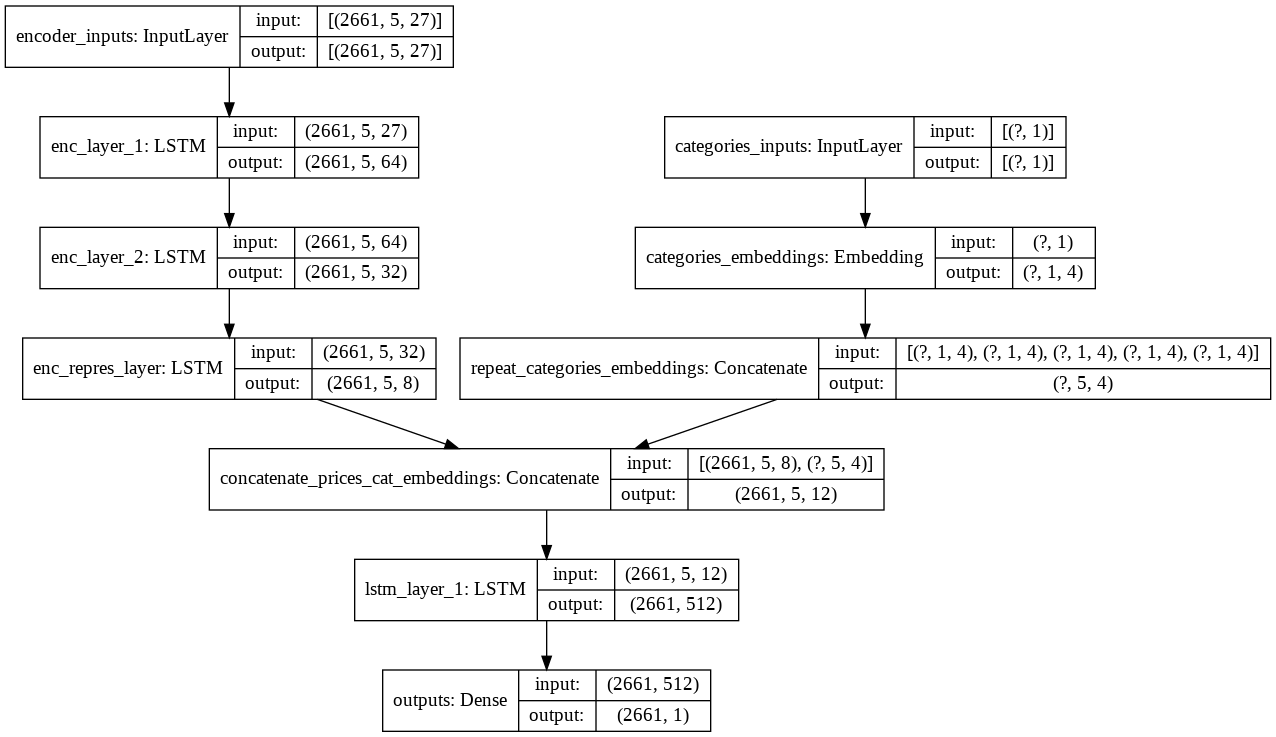

In [0]:
base_lstm_model_graph = plot_model(base_lstm,show_shapes=True, expand_nested=True)
base_lstm_model_graph

In [0]:
base_lstm.save(BASE_LSTM_NOT_FITTED_SAVE_PATH, save_format="h5")

#### 7.3.2 Fine-Tunning Learning Rate

Except metrics 'mean square error' and 'root mean square error' that we used in autoencoder after training the model for price predictions we will calculate 2 more metrics - 'inverse scale root mean square error' (rmse over original/unscaled data) and some metric that measure how many of the price movements through time steps (increase/decrease in price based on previos time step price) the model has predicted correctly. 

We will calculate 'rmse' as it's in the same measurement as the targets - dollar value and is in practice the standard deviation of the predictions.

For the second metric we can use some of the classification metrics like - 'accuracy', 'precision', 'recall' and 'f1'. To determine the appropriate metric let's see whether price increases/decreases are equaly distributed. To check the number of increases/decreases we will use targets and create lag 1 differences.

In [0]:
prices = pd.concat([stocks_targets_train, stocks_targets_val, stocks_targets_test])

In [0]:
prices["price_change"] = prices.groupby(level=0).diff()
prices = prices.dropna()
prices["price_directions"] = (prices["price_change"] >= 0).astype(int)

print("Percent of price increases: {:.2f}%".format(100 * prices["price_directions"].sum() / len(prices.index)))

Percent of price increases: 53.69%


As we see increases are a little more than price decreases b/w time steps so we can use 'accuracy' as metric.

Let's see what is the average stock price of all the samples.

In [0]:
targets_scaler = pickle.load(open(PICKLE_FILE_PATH + TARGETS_SCALER_FILE_NAME, "rb"))
inv_scale_price = targets_scaler.inverse_transform(prices)
print("Average stock price: ${:.2f}".format(inv_scale_price.mean()))

Average stock price: $51.90


After building the model we will fine tune learning rate with 'adam' optimizer. Except default learning rate of 0.001 we will train 2 more models with one root down - 0.01 and one up - 0.0001. Each model will be trained with 100 epochs. We will not do additional regularization to see how much we can reduce the error even with overfitting as financial markets are very hard for modeling due to random/unexplained variation.


##### 7.3.2.1 Training With 0.0001 Learning Rate

In [0]:
base_lstm_0001 = load_model(BASE_LSTM_NOT_FITTED_SAVE_PATH)

In [0]:
base_lstm_0001.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.MSE, metrics = [RootMeanSquaredError()])

In [0]:
base_lstm_0001_tbc = TensorBoard(log_dir=BASE_LSTM_0001_TBC_PATH)
steps_per_epoch=int(len(stocks_prices_train) / batch_size)

In [0]:
base_lstm_0001, base_lstm_0001_hist = training_stateful_rnn(base_lstm_0001, stocks_train, init_epoch=0, epochs=100, steps_per_epoch=steps_per_epoch, val_data=stocks_val, callbacks=[base_lstm_0001_tbc])

Train for 457 steps, validate for 5 steps
457/457 [==============================] - 32s 70ms/step - loss: 4.9239e-04 - root_mean_squared_error: 0.0222 - val_loss: 2.6930e-04 - val_root_mean_squared_error: 0.0164
Train for 457 steps, validate for 5 steps
Epoch 2/2
457/457 [==============================] - 27s 59ms/step - loss: 2.1527e-04 - root_mean_squared_error: 0.0147 - val_loss: 1.6407e-04 - val_root_mean_squared_error: 0.0128
Train for 457 steps, validate for 5 steps
Epoch 3/3
457/457 [==============================] - 27s 60ms/step - loss: 1.7920e-04 - root_mean_squared_error: 0.0134 - val_loss: 2.6550e-04 - val_root_mean_squared_error: 0.0163
Train for 457 steps, validate for 5 steps
Epoch 4/4
457/457 [==============================] - 27s 60ms/step - loss: 1.5931e-04 - root_mean_squared_error: 0.0126 - val_loss: 1.1394e-04 - val_root_mean_squared_error: 0.0107
Train for 457 steps, validate for 5 steps
Epoch 5/5
457/457 [==============================] - 27s 59ms/step - loss: 1

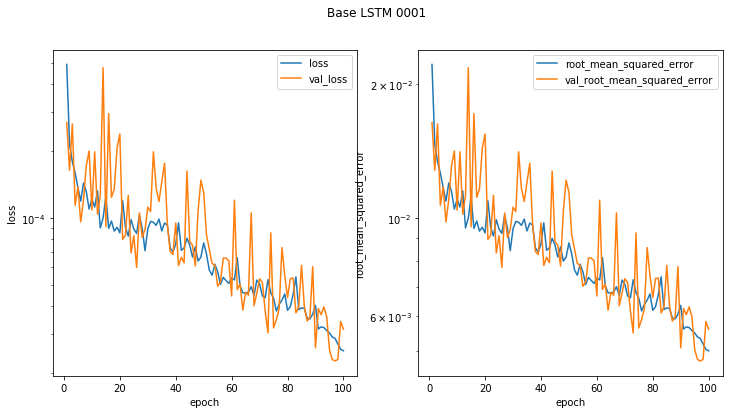

In [0]:
plot_model_history(base_lstm_0001_hist, fig_title="Base LSTM 0001", log=True)

In [0]:
targets_scaler = pickle.load(open(PICKLE_FILE_PATH + TARGETS_SCALER_FILE_NAME, "rb"))
base_lstm_0001_metrics = calculate_model_metrics(base_lstm_0001, base_lstm_0001_hist, train_data=stocks_train, train_targets=stocks_targets_train, val_data=stocks_val, val_targets=stocks_targets_val, test_data=stocks_test, test_targets=stocks_targets_test, scaler=targets_scaler) 

In [0]:
base_lstm_0001_metrics.columns = ["base_lstm_0001"]
base_lstm_0001_metrics

,base_lstm_0001
train_epochs,100.00000
train_mse,0.00003
train_rmse,0.00502
train_inv_scale_rmse,12.40309
train_price_direct_accuracy,0.52957
val_mse,0.00003
val_rmse,0.00561
val_inv_scale_rmse,11.86652
val_price_direct_accuracy,0.61565
test_inv_scale_rmse,11.84133


In practice trading predictions are made for one time step upfront but this is very small sample size and is very unstable metric. We will use 5 time steps for validation and testing to make valuation more stable. Even though they are still small compare to training sample size and training metrics can not be directly compared with validation and testing to determine whether we have overfitting or underfitting.

In [0]:
base_lstm_0001.save(BASE_LSTM_0001_SAVE_PATH, save_format="h5")
pickle.dump(base_lstm_0001_hist, open(BASE_LSTM_0001_HISTORY_PATH, "wb"))
base_lstm_0001_metrics.to_csv(BASE_LSTM_0001_METRICS_PATH)

In [0]:
%tensorboard --logdir '/content/drive/My Drive/Programming/stock_predictions/models/base_lstm/learn_rate_0001/tbc/'

##### 7.3.2.2 Training With 0.001 Learning Rate

In [0]:
base_lstm_001 = load_model(BASE_LSTM_NOT_FITTED_SAVE_PATH)

In [0]:
base_lstm_001.compile(optimizer=Adam(learning_rate=0.001), loss=tf.keras.losses.MSE, metrics = [RootMeanSquaredError()])

In [0]:
base_lstm_001_tbc = TensorBoard(log_dir=BASE_LSTM_001_TBC_PATH)
steps_per_epoch=int(len(stocks_prices_train) / batch_size)

In [0]:
base_lstm_001, base_lstm_001_hist = training_stateful_rnn(base_lstm_001, stocks_train, init_epoch=0, epochs=100, steps_per_epoch=steps_per_epoch, val_data=stocks_val, callbacks=[base_lstm_001_tbc])

Train for 457 steps, validate for 5 steps
457/457 [==============================] - 31s 68ms/step - loss: 5.2784e-04 - root_mean_squared_error: 0.0230 - val_loss: 2.9625e-04 - val_root_mean_squared_error: 0.0172
Train for 457 steps, validate for 5 steps
Epoch 2/2
457/457 [==============================] - 27s 60ms/step - loss: 1.8070e-04 - root_mean_squared_error: 0.0134 - val_loss: 2.6668e-04 - val_root_mean_squared_error: 0.0163
Train for 457 steps, validate for 5 steps
Epoch 3/3
457/457 [==============================] - 28s 62ms/step - loss: 1.7427e-04 - root_mean_squared_error: 0.0132 - val_loss: 1.8087e-04 - val_root_mean_squared_error: 0.0134
Train for 457 steps, validate for 5 steps
Epoch 4/4
457/457 [==============================] - 28s 62ms/step - loss: 1.5027e-04 - root_mean_squared_error: 0.0123 - val_loss: 3.1565e-04 - val_root_mean_squared_error: 0.0178
Train for 457 steps, validate for 5 steps
Epoch 5/5
457/457 [==============================] - 29s 63ms/step - loss: 1

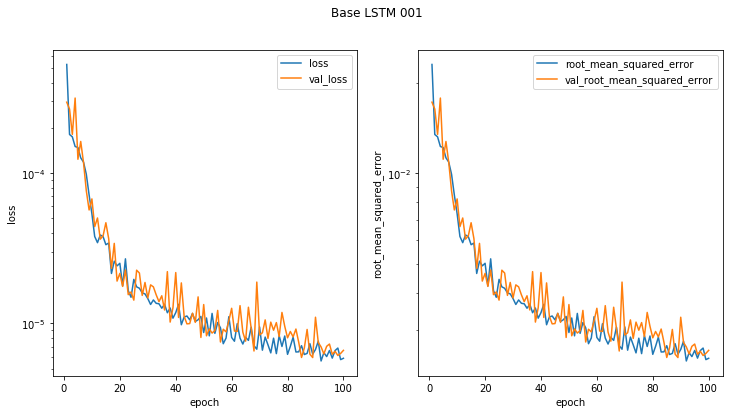

In [0]:
plot_model_history(base_lstm_001_hist, fig_title="Base LSTM 001", log=True)

In [0]:
targets_scaler = pickle.load(open(PICKLE_FILE_PATH + TARGETS_SCALER_FILE_NAME, "rb"))
base_lstm_001_metrics = calculate_model_metrics(base_lstm_001, base_lstm_001_hist, train_data=stocks_train, train_targets=stocks_targets_train, val_data=stocks_val, val_targets=stocks_targets_val, test_data=stocks_test, test_targets=stocks_targets_test, scaler=targets_scaler) 

In [0]:
base_lstm_001_metrics.columns = ["base_lstm_001"]
base_lstm_001_metrics

,base_lstm_001
train_epochs,100.00000
train_mse,0.00001
train_rmse,0.00242
train_inv_scale_rmse,4.89907
train_price_direct_accuracy,0.48913
val_mse,0.00001
val_rmse,0.00257
val_inv_scale_rmse,5.03324
val_price_direct_accuracy,0.46421
test_inv_scale_rmse,5.09813


In [0]:
base_lstm_001.save(BASE_LSTM_001_SAVE_PATH, save_format="h5")
pickle.dump(base_lstm_001_hist, open(BASE_LSTM_001_HISTORY_PATH, "wb"))
base_lstm_001_metrics.to_csv(BASE_LSTM_001_METRICS_PATH)

In [0]:
%tensorboard --logdir '/content/drive/My Drive/Programming/stock_predictions/models/base_lstm/learn_rate_001/tbc/'

##### 7.3.2.3 Training With 0.01 Learning Rate

In [0]:
base_lstm_01 = load_model(BASE_LSTM_NOT_FITTED_SAVE_PATH)

In [0]:
base_lstm_01.compile(optimizer=Adam(learning_rate=0.01), loss=tf.keras.losses.MSE, metrics = [RootMeanSquaredError()])

In [0]:
base_lstm_01_tbc = TensorBoard(log_dir=BASE_LSTM_01_TBC_PATH)
steps_per_epoch=int(len(stocks_prices_train) / batch_size)

In [0]:
base_lstm_01, base_lstm_01_hist = training_stateful_rnn(base_lstm_01, stocks_train, init_epoch=0, epochs=100, steps_per_epoch=steps_per_epoch, val_data=stocks_val, callbacks=[base_lstm_01_tbc])

Train for 457 steps, validate for 5 steps
457/457 [==============================] - 30s 65ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 7.4109e-04 - val_root_mean_squared_error: 0.0272
Train for 457 steps, validate for 5 steps
Epoch 2/2
457/457 [==============================] - 27s 59ms/step - loss: 3.0356e-04 - root_mean_squared_error: 0.0174 - val_loss: 8.0024e-04 - val_root_mean_squared_error: 0.0283
Train for 457 steps, validate for 5 steps
Epoch 3/3
457/457 [==============================] - 27s 58ms/step - loss: 1.9974e-04 - root_mean_squared_error: 0.0141 - val_loss: 1.5631e-04 - val_root_mean_squared_error: 0.0125
Train for 457 steps, validate for 5 steps
Epoch 4/4
457/457 [==============================] - 27s 59ms/step - loss: 1.3220e-04 - root_mean_squared_error: 0.0115 - val_loss: 1.4831e-04 - val_root_mean_squared_error: 0.0122
Train for 457 steps, validate for 5 steps
Epoch 5/5
457/457 [==============================] - 27s 58ms/step - loss: 1.083

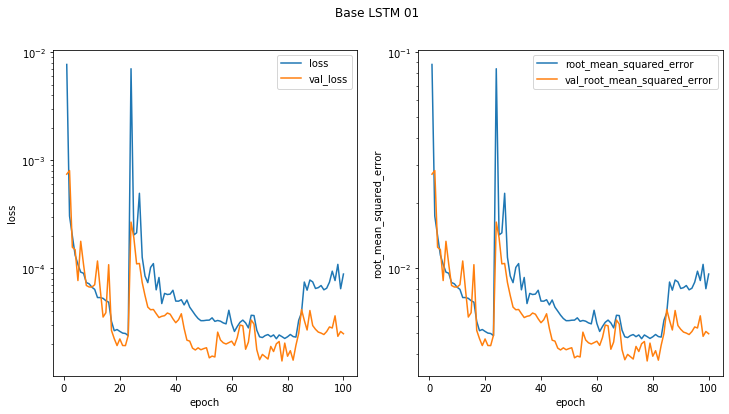

In [0]:
plot_model_history(base_lstm_01_hist, fig_title="Base LSTM 01", log=True)

In [0]:
targets_scaler = pickle.load(open(PICKLE_FILE_PATH + TARGETS_SCALER_FILE_NAME, "rb"))
base_lstm_01_metrics = calculate_model_metrics(base_lstm_01, base_lstm_01_hist, train_data=stocks_train, train_targets=stocks_targets_train, val_data=stocks_val, val_targets=stocks_targets_val, test_data=stocks_test, test_targets=stocks_targets_test, scaler=targets_scaler) 

In [0]:
base_lstm_01_metrics.columns = ["base_lstm_01"]
base_lstm_01_metrics

,base_lstm_01
train_epochs,100.00000
train_mse,0.00009
train_rmse,0.00939
train_inv_scale_rmse,22.85505
train_price_direct_accuracy,0.51558
val_mse,0.00002
val_rmse,0.00497
val_inv_scale_rmse,16.14253
val_price_direct_accuracy,0.59198
test_inv_scale_rmse,15.69171


In [0]:
base_lstm_01.save(BASE_LSTM_01_SAVE_PATH, save_format="h5")
pickle.dump(base_lstm_01_hist, open(BASE_LSTM_01_HISTORY_PATH, "wb"))
base_lstm_01_metrics.to_csv(BASE_LSTM_01_METRICS_PATH)

In [0]:
%tensorboard --logdir '/content/drive/My Drive/Programming/stock_predictions/models/base_lstm/learn_rate_01/tbc/'

##### 7.3.2.4 Results

In [0]:
base_lstm_0001_metrics = pd.read_csv(BASE_LSTM_0001_METRICS_PATH, index_col=[0], header=[0])
base_lstm_001_metrics = pd.read_csv(BASE_LSTM_001_METRICS_PATH, index_col=[0], header=[0])
base_lstm_01_metrics = pd.read_csv(BASE_LSTM_01_METRICS_PATH, index_col=[0], header=[0])
metrics = pd.concat([base_lstm_0001_metrics, base_lstm_001_metrics, base_lstm_01_metrics], axis=1)

In [0]:
metrics

,base_lstm_0001,base_lstm_001,base_lstm_01
train_epochs,100.00000,100.00000,100.00000
train_mse,0.00003,0.00001,0.00009
train_rmse,0.00502,0.00242,0.00939
train_inv_scale_rmse,12.40309,4.89907,22.85505
train_price_direct_accuracy,0.52957,0.48913,0.51558
val_mse,0.00003,0.00001,0.00002
val_rmse,0.00561,0.00257,0.00497
val_inv_scale_rmse,11.86652,5.03324,16.14253
val_price_direct_accuracy,0.61565,0.46421,0.59198
test_inv_scale_rmse,11.84133,5.09813,15.69171


As we see 'base_lstm' with learning rate of 0.001 gives best results in all metrics except price direction accuracy. As we mentioned above 'train_inv_scale_rmse' is bigger than 'val_inv_scale_rmse' and 'test_inv_scale_rmse' because of the smaller validation and training sample sizes this can be seen in 'base_lstm_0001' and 'base_lstm_01'. 'base_lstm_001' has smaller 'train_inv_scale_rmse' than validation and test data which is a sign of overfitting. The same pattern can be observed in price directional accuracy where 'base_lstm_001' strangly perform worse than 'base_lstm_0001' and 'base_lstm_01'.

Based on the final metrics after 100 epochs and above plots of dynamics in errors the best performing model is with learning rate of 0.001. This model has signs of overfitting but even though it has 'rmse' (standard deviation of the predictions) of about \$5. Which compared with average stock price of \$51.9 is a huge error.

Let's train best base model for another 200 epochs. 

In [0]:
base_lstm_001 = load_model(BASE_LSTM_001_SAVE_PATH)
base_lstm_001_hist = pickle.load(open(BASE_LSTM_001_HISTORY_PATH, "rb"))
base_lstm_001_tbc = TensorBoard(log_dir=BASE_LSTM_001_TBC_PATH)
steps_per_epoch=int(len(stocks_prices_train) / batch_size)

In [0]:
base_lstm_001, base_lstm_001_hist = training_stateful_rnn(base_lstm_001, stocks_train, init_epoch=100, epochs=200, steps_per_epoch=steps_per_epoch, val_data=stocks_val, callbacks=[base_lstm_001_tbc], history=base_lstm_001_hist)

Train for 457 steps, validate for 5 steps
Epoch 101/101
457/457 [==============================] - 31s 67ms/step - loss: 6.0658e-06 - root_mean_squared_error: 0.0025 - val_loss: 5.8070e-06 - val_root_mean_squared_error: 0.0024
Train for 457 steps, validate for 5 steps
Epoch 102/102
457/457 [==============================] - 25s 55ms/step - loss: 7.1035e-06 - root_mean_squared_error: 0.0027 - val_loss: 5.5533e-06 - val_root_mean_squared_error: 0.0024
Train for 457 steps, validate for 5 steps
Epoch 103/103
457/457 [==============================] - 25s 55ms/step - loss: 5.7826e-06 - root_mean_squared_error: 0.0024 - val_loss: 6.4210e-06 - val_root_mean_squared_error: 0.0025
Train for 457 steps, validate for 5 steps
Epoch 104/104
457/457 [==============================] - 26s 56ms/step - loss: 5.8693e-06 - root_mean_squared_error: 0.0024 - val_loss: 6.4497e-06 - val_root_mean_squared_error: 0.0025
Train for 457 steps, validate for 5 steps
Epoch 105/105
457/457 [===========================

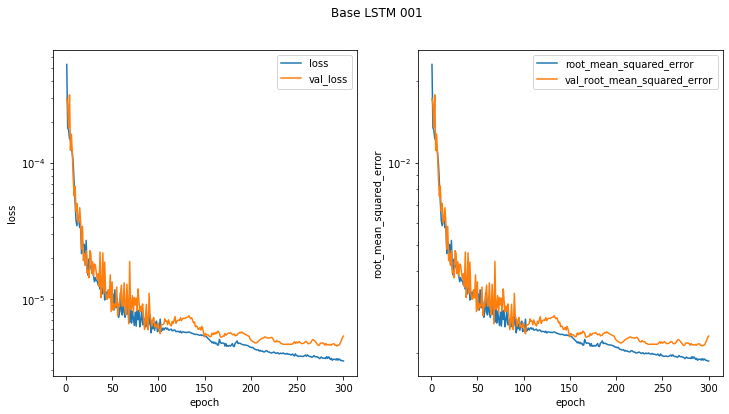

In [0]:
plot_model_history(base_lstm_001_hist, fig_title="Base LSTM 001", log=True)

In [0]:
targets_scaler = pickle.load(open(PICKLE_FILE_PATH + TARGETS_SCALER_FILE_NAME, "rb"))
base_lstm_001_metrics = calculate_model_metrics(base_lstm_001, base_lstm_001_hist, train_data=stocks_train, train_targets=stocks_targets_train, val_data=stocks_val, val_targets=stocks_targets_val, test_data=stocks_test, test_targets=stocks_targets_test, scaler=targets_scaler)

In [0]:
base_lstm_001_metrics

,base_lstm_model
train_epochs,300.00000
train_mse,0.00000
train_rmse,0.00187
train_inv_scale_rmse,3.68804
train_price_direct_accuracy,0.48720
val_mse,0.00001
val_rmse,0.00231
val_inv_scale_rmse,4.50687
val_price_direct_accuracy,0.44025
test_inv_scale_rmse,4.50196


The model achieve about 1.5 lower 'train_inv_scale_rmse' but only 0.5 in validation  and testing data - a sign of overfitting which can be seen on the plot too. Test and validation price direction accuracies are even worse than before.

In [0]:
base_lstm_001.save(BASE_LSTM_001_SAVE_PATH, save_format="h5")
pickle.dump(base_lstm_001_hist, open(BASE_LSTM_001_HISTORY_PATH, "wb"))
base_lstm_001_metrics.to_csv(BASE_LSTM_001_METRICS_PATH)

In [0]:
%tensorboard --logdir '/content/drive/My Drive/Programming/stock_predictions/models/base_lstm/learn_rate_0001/tbc/'

### 7.4 Stacked LSTM Model

#### 7.4.1 Building Stacked LSTM Model 

We will try deeper LSTM model with 3 layers first with 512 units, second with 256 and third with 128. 

In [0]:
embed_model = load_model(EMBEDDING_MODEL_SAVE_PATH)

In [0]:
# tried with wider 1024/512/256 architecture with about 8,200,000 trainable params but colab reaches limits after about 2 hours of training 
LSTM_L1_UNITS = 512
LSTM_L2_UNITS = 256
LSTM_L3_UNITS = 128

stacked_lstm_l1 = LSTM(LSTM_L1_UNITS, stateful=True, return_sequences=True, name="lstm_layer_1")
stacked_lstm_l2 = LSTM(LSTM_L2_UNITS, stateful=True, return_sequences=True, name="lstm_layer_2")
stacked_lstm_l3 = LSTM(LSTM_L3_UNITS, stateful=True, name="lstm_layer_3")
output = Dense(1, name="output")

lstm_l1_outputs = stacked_lstm_l1(embed_model.output)
lstm_l2_outputs = stacked_lstm_l2(lstm_l1_outputs)
lstm_l3_outputs = stacked_lstm_l3(lstm_l2_outputs)
outputs = output(lstm_l3_outputs)

stacked_lstm = Model(inputs=embed_model.input, outputs=outputs, name="stacked_lstm")

In [0]:
stacked_lstm.summary()

Model: "stacked_lstm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(2661, 5, 27)]      0                                            
__________________________________________________________________________________________________
enc_layer_1 (LSTM)              (2661, 5, 64)        23552       encoder_inputs[0][0]             
__________________________________________________________________________________________________
categories_inputs (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
enc_layer_2 (LSTM)              (2661, 5, 32)        12416       enc_layer_1[0][0]                
_______________________________________________________________________________________

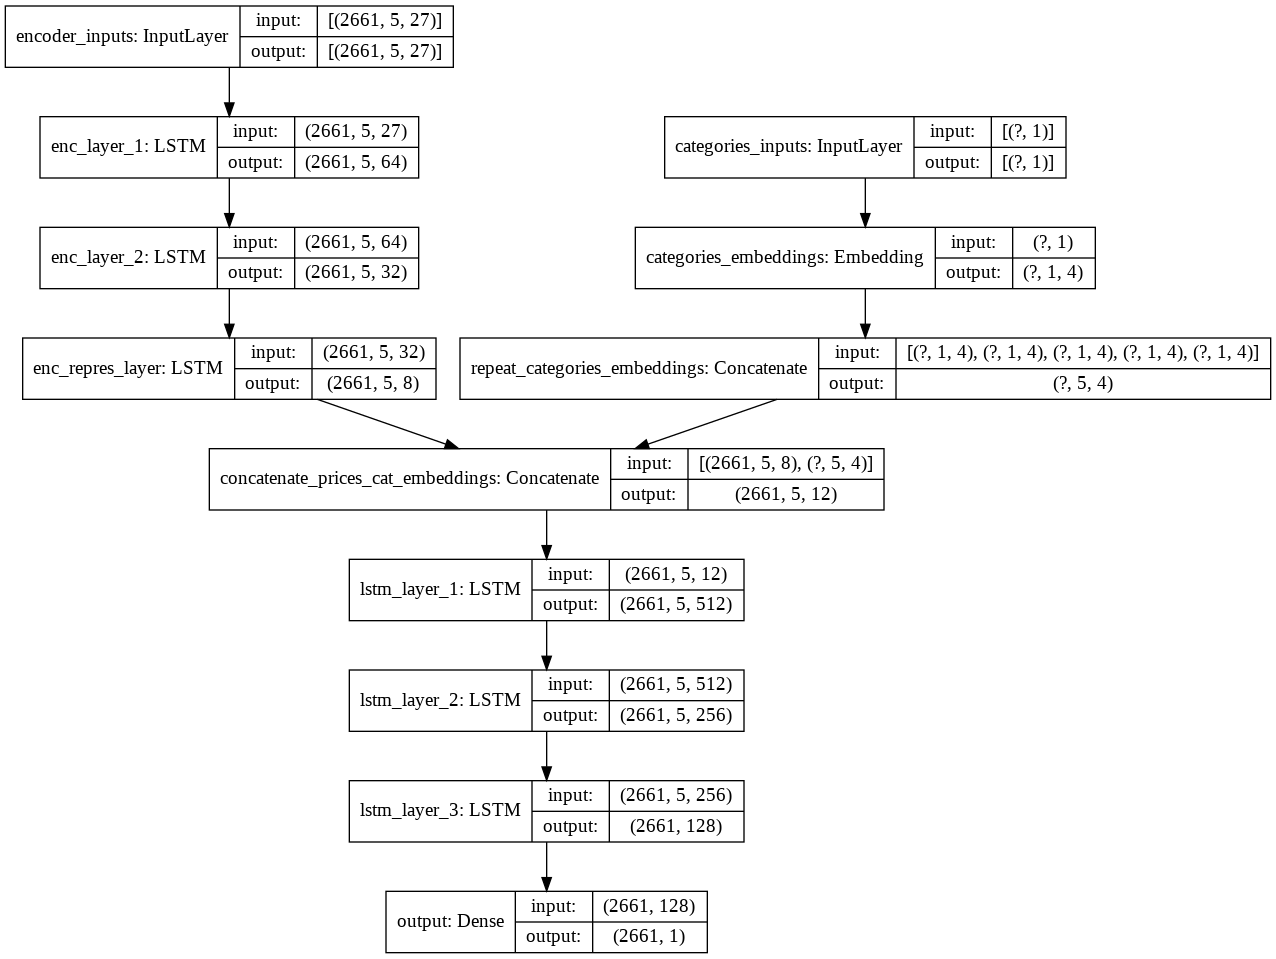

In [0]:
stacked_lstm_model_graph = plot_model(stacked_lstm, show_shapes=True, expand_nested=True)
stacked_lstm_model_graph

#### 7.4.2 Training Stacked LSTM Model

We will train stacked LSTM with 300 epochs.

In [0]:
stacked_lstm.compile(optimizer=Adam(learning_rate=0.001), loss=tf.keras.losses.MSE, metrics = [RootMeanSquaredError()])

In [0]:
stacked_lstm_tbc = TensorBoard(log_dir=STACKED_LSTM_TBC_PATH)
steps_per_epoch=int(len(stocks_prices_train) / batch_size)

In [0]:
stacked_lstm, stacked_lstm_hist = training_stateful_rnn(stacked_lstm, stocks_train, init_epoch=0, epochs=300, steps_per_epoch=steps_per_epoch, val_data=stocks_val, callbacks=[stacked_lstm_tbc])

Train for 457 steps, validate for 5 steps
457/457 [==============================] - 44s 96ms/step - loss: 7.0924e-04 - root_mean_squared_error: 0.0266 - val_loss: 6.7489e-04 - val_root_mean_squared_error: 0.0260
Train for 457 steps, validate for 5 steps
Epoch 2/2
457/457 [==============================] - 32s 71ms/step - loss: 2.3459e-04 - root_mean_squared_error: 0.0153 - val_loss: 5.4972e-04 - val_root_mean_squared_error: 0.0234
Train for 457 steps, validate for 5 steps
Epoch 3/3
457/457 [==============================] - 33s 71ms/step - loss: 2.6865e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.6207e-04 - val_root_mean_squared_error: 0.0190
Train for 457 steps, validate for 5 steps
Epoch 4/4
457/457 [==============================] - 33s 72ms/step - loss: 1.5195e-04 - root_mean_squared_error: 0.0123 - val_loss: 3.6328e-04 - val_root_mean_squared_error: 0.0191
Train for 457 steps, validate for 5 steps
Epoch 5/5
457/457 [==============================] - 33s 73ms/step - loss: 1

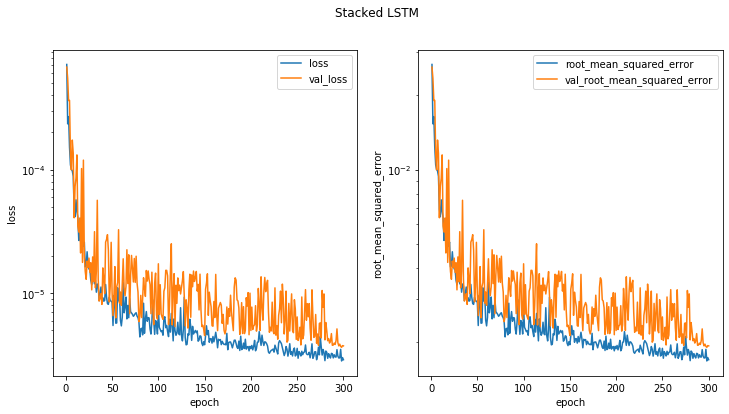

In [0]:
plot_model_history(stacked_lstm_hist, fig_title="Stacked LSTM", log=True)

In [0]:
targets_scaler = pickle.load(open(PICKLE_FILE_PATH + TARGETS_SCALER_FILE_NAME, "rb"))
stacked_lstm_metrics = calculate_model_metrics(stacked_lstm, stacked_lstm_hist, train_data=stocks_train, train_targets=stocks_targets_train, val_data=stocks_val, val_targets=stocks_targets_val, test_data=stocks_test, test_targets=stocks_targets_test, scaler=targets_scaler)

In [0]:
stacked_lstm_metrics

,stacked_lstm
train_epochs,300.00000
train_mse,0.00000
train_rmse,0.00170
train_inv_scale_rmse,3.50444
train_price_direct_accuracy,0.51365
val_mse,0.00000
val_rmse,0.00194
val_inv_scale_rmse,3.78100
val_price_direct_accuracy,0.52772
test_inv_scale_rmse,3.72403


The model achieved better results in validation and test data in comparison with base LSTM. Price direction accuracy is better too but the inversed scale rmse (standard deviation of the predictions) are very high and the model is not applicable in practice. The model needs more training.

In [0]:
stacked_lstm.save(STACKED_LSTM_SAVE_PATH, save_format="h5")
pickle.dump(stacked_lstm_hist, open(STACKED_LSTM_HISTORY_PATH, "wb"))
stacked_lstm_metrics.to_csv(STACKED_LSTM_METRICS_PATH)

In [0]:
%tensorboard --logdir '/content/drive/My Drive/Programming/stock_predictions/models/stacked_lstm/tbc/'

### 7.5 Single Stock Stacked LSTM Models

After we tested 2 RNN architectures we saw that the error is too big and the models can not make good approximations. The reasons can be several - most likely the data has big unexplained variation because there are a lot of different stocks in the data that doesn't adhere to the same paterns. Let's try 2 more architectures trained only on single stock historical data to see if that is the reason for poor performance. The first RNN will use the encoder for dimentionality reduction and deep LSTM for predictions and the second will not use encoder but only deep LSTM. That way we can asses the usefulness of the encoder in the model. For training single stock model we will use 'AAPL' ticker.

After some testing single stock models doesn't perform well with 0.001 learning rate and they will be trained with 0.0001.


#### 7.5.1 Preparing Single Stock Stacked LSTM Dataset



In [0]:
single_stock_prices_train = pd.read_csv(DATA_FILE_PATH + TRAIN_DATA_DIR + PRICES_TRAIN_DATASET_FILENAME, index_col=[0,1], header=[0,1])
single_stock_targets_train = pd.read_csv(DATA_FILE_PATH +  TRAIN_DATA_DIR + TARGETS_TRAIN_DATASET_FILENAME, index_col=[0,1], header=[0,1])

single_stock_prices_val = pd.read_csv(DATA_FILE_PATH + VAL_DATA_DIR + PRICES_VALIDATION_DATASET_FILENAME, index_col=[0,1], header=[0,1])
single_stock_targets_val = pd.read_csv(DATA_FILE_PATH + VAL_DATA_DIR + TARGETS_VALIDATION_DATASET_FILENAME, index_col=[0,1], header=[0,1])

single_stock_prices_test = pd.read_csv(DATA_FILE_PATH + TEST_DATA_DIR + PRICES_TEST_DATASET_FILENAME, index_col=[0,1], header=[0,1])
single_stock_targets_test = pd.read_csv(DATA_FILE_PATH + TEST_DATA_DIR + TARGETS_TEST_DATASET_FILENAME, index_col=[0,1], header=[0,1])

In [0]:
stock_ticker = "AAPL"

In [0]:
single_stock_prices_train = single_stock_prices_train[single_stock_prices_train.index.get_level_values(0) == stock_ticker]
single_stock_targets_train = single_stock_targets_train[single_stock_targets_train.index.get_level_values(0) == stock_ticker]

single_stock_prices_val = single_stock_prices_val[single_stock_prices_val.index.get_level_values(0) == stock_ticker]
single_stock_targets_val = single_stock_targets_val[single_stock_targets_val.index.get_level_values(0) == stock_ticker]

single_stock_prices_test = single_stock_prices_test[single_stock_prices_test.index.get_level_values(0) == stock_ticker]
single_stock_targets_test = single_stock_targets_test[single_stock_targets_test.index.get_level_values(0) == stock_ticker]

In [0]:
num_fetures_count = single_stock_prices_train["lag_1"].shape[1] # 27
single_stock_batch_size = 1

In [0]:
single_stock_train = tf.data.Dataset.from_tensor_slices((single_stock_prices_train.values.reshape(single_stock_prices_train.values.shape[0], TIME_STEPS, num_fetures_count), single_stock_targets_train.values))
single_stock_train = single_stock_train.batch(single_stock_batch_size)

In [0]:
single_stock_train

<BatchDataset shapes: ((None, 5, 27), (None, 1)), types: (tf.float64, tf.float64)>

In [0]:
single_stock_val = tf.data.Dataset.from_tensor_slices((single_stock_prices_val.values.reshape(single_stock_prices_val.values.shape[0], TIME_STEPS, num_fetures_count), single_stock_targets_val.values))
single_stock_val = single_stock_val.batch(single_stock_batch_size)

In [0]:
single_stock_val

<BatchDataset shapes: ((None, 5, 27), (None, 1)), types: (tf.float64, tf.float64)>

In [0]:
single_stock_test = tf.data.Dataset.from_tensor_slices((single_stock_prices_test.values.reshape(single_stock_prices_test.values.shape[0], TIME_STEPS, num_fetures_count), single_stock_targets_test.values))
single_stock_test = single_stock_test.batch(single_stock_batch_size)

In [0]:
single_stock_test

<BatchDataset shapes: ((None, 5, 27), (None, 1)), types: (tf.float64, tf.float64)>

#### 7.5.2 Single Stock Stacked LSTM With Encoder

##### 7.5.2.1 Building Single Stock Stacked LSTM With Encoder

For training sigle stock LSTM we have only 457 (historical days) samples so we will fit the model with batch size of 1. Have to mention that with such small sample size the network will overfit the data. We won't do regularization to see what minimum error can be achieved even with overfitting. As autoencoder is trained with stateful LSTM and batch sized is fixed to 2661 samples we need to build new model with batch size of 1 and transfer the weights from already trained model. Categorical input will not be used here as single stock corresponds to exactly one sector.

In [0]:
encoder_layer_1 = LSTM(units=ENC_LAYER_1_UNITS, return_sequences=True, stateful=True, name="enc_layer_1")
encoder_layer_2 = LSTM(units=ENC_LAYER_2_UNITS, return_sequences=True, stateful=True, name="enc_layer_2")
repres_layer = LSTM(units=REPRES_DIM, return_sequences=True, stateful=True, name="enc_repres_layer")

In [0]:
enc_inputs = Input(shape=(TIME_STEPS, num_fetures_count), batch_size=single_stock_batch_size, name="encoder_inputs")
encoded = encoder_layer_1(enc_inputs)
encoded = encoder_layer_2(encoded)
enc_repres_output = repres_layer(encoded)

In [0]:
single_stock_encoder = Model(inputs=enc_inputs, outputs=enc_repres_output, name="single_stock_encoder")

In [0]:
encoder = load_model(ENCODER_SAVE_PATH)
single_stock_encoder.set_weights(encoder.get_weights())
single_stock_encoder.trainable = False

In [0]:
LSTM_L1_UNITS = 512
LSTM_L2_UNITS = 256
LSTM_L3_UNITS = 128

stacked_lstm_l1 = LSTM(LSTM_L1_UNITS, stateful=True, return_sequences=True, name="lstm_layer_1")
stacked_lstm_l2 = LSTM(LSTM_L2_UNITS, stateful=True, return_sequences=True, name="lstm_layer_2")
stacked_lstm_l3 = LSTM(LSTM_L3_UNITS, stateful=True, name="lstm_layer_3")
output = Dense(1, name="output")

lstm_l1_outputs = stacked_lstm_l1(single_stock_encoder.output)
lstm_l2_outputs = stacked_lstm_l2(lstm_l1_outputs)
lstm_l3_outputs = stacked_lstm_l3(lstm_l2_outputs)
outputs = output(lstm_l3_outputs)

single_stock_lstm_enc = Model(inputs=single_stock_encoder.input, outputs=outputs, name="single_stock_lstm_enc")

In [0]:
single_stock_lstm_enc.summary()

Model: "single_stock_lstm_enc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(1, 5, 27)]              0         
_________________________________________________________________
enc_layer_1 (LSTM)           (1, 5, 64)                23552     
_________________________________________________________________
enc_layer_2 (LSTM)           (1, 5, 32)                12416     
_________________________________________________________________
enc_repres_layer (LSTM)      (1, 5, 8)                 1312      
_________________________________________________________________
lstm_layer_1 (LSTM)          (1, 5, 512)               1067008   
_________________________________________________________________
lstm_layer_2 (LSTM)          (1, 5, 256)               787456    
_________________________________________________________________
lstm_layer_3 (LSTM)          (1, 128)        

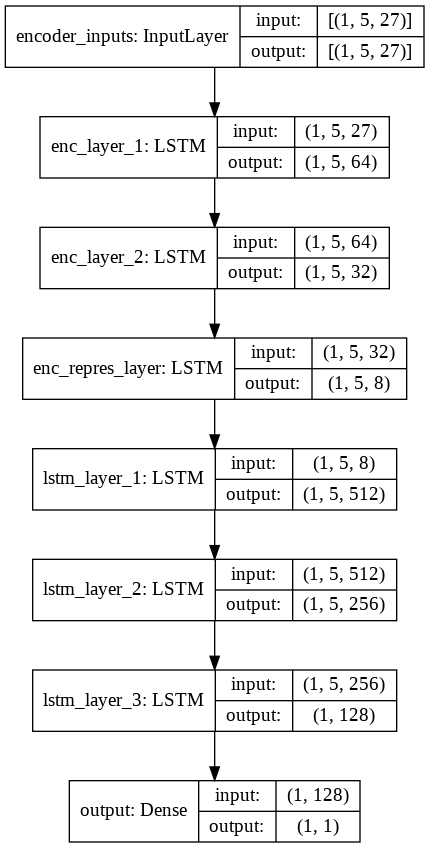

In [0]:
single_stock_lstm_enc_graph = plot_model(single_stock_lstm_enc, show_shapes=True, expand_nested=True)
single_stock_lstm_enc_graph

In [0]:
single_stock_lstm_enc.save(SINGLE_STOCK_LSTM_ENC_SAVE_PATH, save_format="h5")

##### 7.5.2.2 Training Single Stock Stacked LSTM With Encoder



In [0]:
single_stock_lstm_enc = load_model(SINGLE_STOCK_LSTM_ENC_SAVE_PATH)

In [0]:
steps_per_epoch=len(single_stock_prices_train)

In [0]:
single_stock_lstm_enc.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.MSE, metrics = [RootMeanSquaredError()])
single_stock_lstm_enc, single_stock_lstm_enc_hist = training_stateful_rnn(single_stock_lstm_enc, single_stock_train, init_epoch=0, epochs=300, steps_per_epoch=steps_per_epoch, val_data=single_stock_val)

Train for 457 steps, validate for 5 steps
457/457 [==============================] - 16s 34ms/step - loss: 4.2689e-04 - root_mean_squared_error: 0.0207 - val_loss: 3.7684e-05 - val_root_mean_squared_error: 0.0061
Train for 457 steps, validate for 5 steps
Epoch 2/2
457/457 [==============================] - 11s 23ms/step - loss: 9.9874e-05 - root_mean_squared_error: 0.0100 - val_loss: 7.5456e-06 - val_root_mean_squared_error: 0.0027
Train for 457 steps, validate for 5 steps
Epoch 3/3
457/457 [==============================] - 11s 23ms/step - loss: 7.0339e-05 - root_mean_squared_error: 0.0084 - val_loss: 8.4676e-06 - val_root_mean_squared_error: 0.0029
Train for 457 steps, validate for 5 steps
Epoch 4/4
457/457 [==============================] - 10s 23ms/step - loss: 5.6258e-05 - root_mean_squared_error: 0.0075 - val_loss: 1.3300e-05 - val_root_mean_squared_error: 0.0036
Train for 457 steps, validate for 5 steps
Epoch 5/5
457/457 [==============================] - 11s 23ms/step - loss: 4

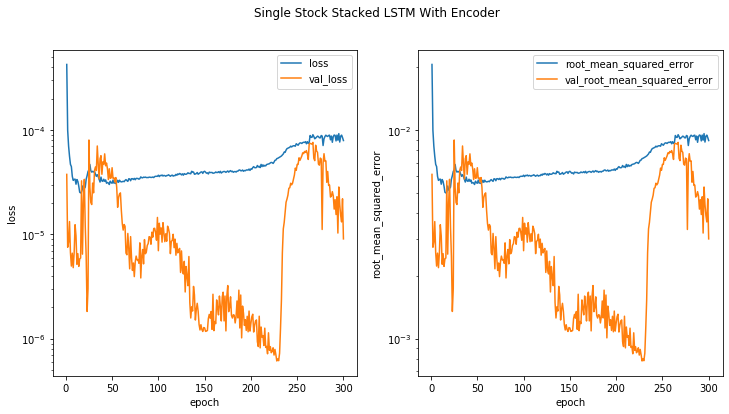

In [0]:
plot_model_history(single_stock_lstm_enc_hist, fig_title="Single Stock Stacked LSTM With Encoder", log=True)

In [0]:
targets_scaler = pickle.load(open(PICKLE_FILE_PATH + TARGETS_SCALER_FILE_NAME, "rb"))
single_stock_lstm_enc_metrics = calculate_model_metrics(single_stock_lstm_enc, single_stock_lstm_enc_hist, train_data=single_stock_train, train_targets=single_stock_targets_train, val_data=single_stock_val, val_targets=single_stock_targets_val, test_data=single_stock_test, test_targets=single_stock_targets_test, scaler=targets_scaler)

In [0]:
single_stock_lstm_enc_metrics

,single_stock_lstm_enc
train_epochs,300.00000
train_mse,0.00008
train_rmse,0.00892
train_inv_scale_rmse,43.97110
train_price_direct_accuracy,0.52193
val_mse,0.00001
val_rmse,0.00301
val_inv_scale_rmse,5.74632
val_price_direct_accuracy,0.00000
test_inv_scale_rmse,11.49058


As we can see from model metrics and plots the model doesn't achive better result in comparison with multi stocks models.

In [0]:
single_stock_lstm_enc.save(SINGLE_STOCK_LSTM_ENC_SAVE_PATH, save_format="h5")
pickle.dump(single_stock_lstm_enc_hist, open(SINGLE_STOCK_LSTM_ENC_HISTORY_PATH, "wb"))
single_stock_lstm_enc_metrics.to_csv(SINGLE_STOCK_LSTM_ENC_METRICS_PATH)

#### 7.5.3 Single Stock Stacked LSTM Without Encoder

##### 7.5.3.1 Building Single Stock Stacked LSTM Without Encoder


In [0]:
LSTM_L1_UNITS = 512
LSTM_L2_UNITS = 256
LSTM_L3_UNITS = 128

inputs = Input(shape=(TIME_STEPS, num_fetures_count), batch_size=single_stock_batch_size, name="inputs")
stacked_lstm_l1 = LSTM(LSTM_L1_UNITS, stateful=True, return_sequences=True, name="lstm_layer_1")
stacked_lstm_l2 = LSTM(LSTM_L2_UNITS, stateful=True, return_sequences=True, name="lstm_layer_2")
stacked_lstm_l3 = LSTM(LSTM_L3_UNITS, stateful=True, name="lstm_layer_3")
output = Dense(1, name="outputs")

lstm_l1_outputs = stacked_lstm_l1(inputs)
lstm_l2_outputs = stacked_lstm_l2(lstm_l1_outputs)
lstm_l3_outputs = stacked_lstm_l3(lstm_l2_outputs)
outputs = output(lstm_l3_outputs)

single_stock_lstm = Model(inputs=inputs, outputs=outputs, name="single_stock_lstm")

In [0]:
single_stock_lstm.summary()

Model: "single_stock_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(1, 5, 27)]              0         
_________________________________________________________________
lstm_layer_1 (LSTM)          (1, 5, 512)               1105920   
_________________________________________________________________
lstm_layer_2 (LSTM)          (1, 5, 256)               787456    
_________________________________________________________________
lstm_layer_3 (LSTM)          (1, 128)                  197120    
_________________________________________________________________
outputs (Dense)              (1, 1)                    129       
Total params: 2,090,625
Trainable params: 2,090,625
Non-trainable params: 0
_________________________________________________________________


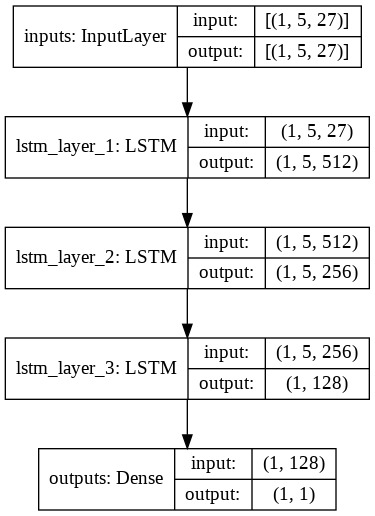

In [0]:
single_stock_lstm_graph = plot_model(single_stock_lstm, show_shapes=True, expand_nested=True)
single_stock_lstm_graph

In [0]:
single_stock_lstm.save(SINGLE_STOCK_LSTM_SAVE_PATH, save_format="h5")

##### 7.5.3.2 Training Single Stock Stacked LSTM Without Encoder


In [0]:
single_stock_lstm = load_model(SINGLE_STOCK_LSTM_SAVE_PATH)

In [0]:
steps_per_epoch=len(single_stock_prices_train)

In [0]:
single_stock_lstm.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.MSE, metrics = [RootMeanSquaredError()])
single_stock_lstm, single_stock_lstm_hist = training_stateful_rnn(single_stock_lstm, single_stock_train, init_epoch=0, epochs=300, steps_per_epoch=steps_per_epoch, val_data=single_stock_val)

Train for 457 steps, validate for 5 steps
457/457 [==============================] - 8s 18ms/step - loss: 0.0011 - root_mean_squared_error: 0.0324 - val_loss: 1.1729e-04 - val_root_mean_squared_error: 0.0108
Train for 457 steps, validate for 5 steps
Epoch 2/2
457/457 [==============================] - 6s 13ms/step - loss: 4.8285e-05 - root_mean_squared_error: 0.0069 - val_loss: 1.1626e-04 - val_root_mean_squared_error: 0.0108
Train for 457 steps, validate for 5 steps
Epoch 3/3
457/457 [==============================] - 6s 14ms/step - loss: 4.7016e-05 - root_mean_squared_error: 0.0069 - val_loss: 3.0579e-04 - val_root_mean_squared_error: 0.0175
Train for 457 steps, validate for 5 steps
Epoch 4/4
457/457 [==============================] - 6s 13ms/step - loss: 4.1719e-05 - root_mean_squared_error: 0.0065 - val_loss: 1.5688e-04 - val_root_mean_squared_error: 0.0125
Train for 457 steps, validate for 5 steps
Epoch 5/5
457/457 [==============================] - 6s 13ms/step - loss: 4.0946e-05

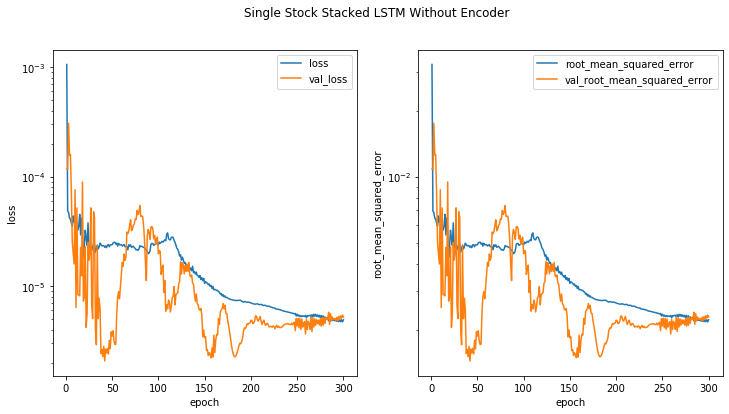

In [0]:
plot_model_history(single_stock_lstm_hist, fig_title="Single Stock Stacked LSTM Without Encoder", log=True)

In [0]:
targets_scaler = pickle.load(open(PICKLE_FILE_PATH + TARGETS_SCALER_FILE_NAME, "rb"))
single_stock_lstm_metrics = calculate_model_metrics(single_stock_lstm, single_stock_lstm_hist, train_data=single_stock_train, train_targets=single_stock_targets_train, val_data=single_stock_val, val_targets=single_stock_targets_val, test_data=single_stock_test, test_targets=single_stock_targets_test, scaler=targets_scaler)

In [0]:
single_stock_lstm_metrics

,single_stock_lstm
train_epochs,300.00000
train_mse,0.00000
train_rmse,0.00222
train_inv_scale_rmse,16.61307
train_price_direct_accuracy,0.53728
val_mse,0.00001
val_rmse,0.00229
val_inv_scale_rmse,4.38643
val_price_direct_accuracy,0.25000
test_inv_scale_rmse,7.25799


In [0]:
single_stock_lstm.save(SINGLE_STOCK_LSTM_SAVE_PATH, save_format="h5")
pickle.dump(single_stock_lstm_hist, open(SINGLE_STOCK_LSTM_HISTORY_PATH, "wb"))
single_stock_lstm_metrics.to_csv(SINGLE_STOCK_LSTM_METRICS_PATH)

## Results
***

Before continue with results we have to mention that models need more training althought it's quastionable that the results will improve much having in mind high inverse scale rmse even in the best performing model.

We will compare the results of base lstm, stacked lstm, single stock stacked lstm with encoder and single stock stacked lstm without encoder models. First let's see metrics.

In [0]:
base_lstm_metrics = pd.read_csv(BASE_LSTM_001_METRICS_PATH, index_col=[0], header=[0])
stacked_lstm_metrics = pd.read_csv(STACKED_LSTM_METRICS_PATH, index_col=[0], header=[0])
single_stock_lstm_enc_metrics = pd.read_csv(SINGLE_STOCK_LSTM_ENC_METRICS_PATH, index_col=[0], header=[0])
single_stock_lstm_metrics = pd.read_csv(SINGLE_STOCK_LSTM_METRICS_PATH, index_col=[0], header=[0])
metrics = pd.concat([base_lstm_metrics, stacked_lstm_metrics, single_stock_lstm_enc_metrics, single_stock_lstm_metrics], axis=1)
metrics

,base_lstm_model,stacked_lstm,single_stock_lstm_enc,single_stock_lstm
train_epochs,300.00000,300.00000,300.00000,300.00000
train_mse,0.00000,0.00000,0.00008,0.00000
train_rmse,0.00187,0.00170,0.00892,0.00222
train_inv_scale_rmse,3.68804,3.50444,43.97110,16.61307
train_price_direct_accuracy,0.48720,0.51365,0.52193,0.53728
val_mse,0.00001,0.00000,0.00001,0.00001
val_rmse,0.00231,0.00194,0.00301,0.00229
val_inv_scale_rmse,4.50687,3.78100,5.74632,4.38643
val_price_direct_accuracy,0.44025,0.52772,0.00000,0.25000
test_inv_scale_rmse,4.50196,3.72403,11.49058,7.25799


In almost all metrics 'stacked_lstm' model outperform all others. At second place is 'base_lstm_model' and after that are 'single_stock_lstm' and 'single_stock_lstm_enc'. Opposite of my expectations models trained with all stocks are performing much better than single stock models this could be because of the very small sample sizes that single models used for training and the need for more epochs because of the lower learning rate. Single stock model should easily overfit the data and give better results at least on training metrics. Single stock model with encoder gives worse results than the one without encoder again this can be caused because autoencoder needs more training or the dimentions of the representational feature vector are not enough. Expectedly the deep lstm gives better results than the one with one hidden layer. Price direction accuracy is not better than random and much worse in single stock models.

Now let's plot predictions of different models.

In [0]:
base_lstm = load_model(BASE_LSTM_001_SAVE_PATH)
stacked_lstm = load_model(STACKED_LSTM_SAVE_PATH)
single_stock_lstm_enc = load_model(SINGLE_STOCK_LSTM_ENC_SAVE_PATH)
single_stock_lstm = load_model(SINGLE_STOCK_LSTM_SAVE_PATH)

In [0]:
targets_scaler = pickle.load(open(PICKLE_FILE_PATH + TARGETS_SCALER_FILE_NAME, "rb"))

In [0]:
train_actual_prices = pd.DataFrame(targets_scaler.inverse_transform(single_stock_targets_train), index=single_stock_targets_train.index, columns=single_stock_targets_train.columns)
val_actual_prices = pd.DataFrame(targets_scaler.inverse_transform(single_stock_targets_val), index=single_stock_targets_val.index, columns=single_stock_targets_val.columns)
test_actual_prices = pd.DataFrame(targets_scaler.inverse_transform(single_stock_targets_test), index=single_stock_targets_test.index, columns=single_stock_targets_test.columns)
val_test_actual_prices = pd.concat([val_actual_prices, test_actual_prices])


all_stocks_val_test = stocks_val.concatenate(stocks_test)
all_stocks_val_test_index = pd.concat([stocks_prices_val, stocks_prices_test]).index

base_lstm_val_test_pred_prices = pd.DataFrame(targets_scaler.inverse_transform(base_lstm.predict(all_stocks_val_test)), index=all_stocks_val_test_index, columns=["base_lstm_predictions"])
base_lstm_val_test_pred_prices = base_lstm_val_test_pred_prices[base_lstm_val_test_pred_prices.index.get_level_values(0) == stock_ticker]

stacked_lstm_val_test_pred_prices = pd.DataFrame(targets_scaler.inverse_transform(stacked_lstm.predict(all_stocks_val_test)), index=all_stocks_val_test_index, columns=["stacked_lstm_predictions"])
stacked_lstm_val_test_pred_prices = stacked_lstm_val_test_pred_prices[stacked_lstm_val_test_pred_prices.index.get_level_values(0) == stock_ticker]


single_stock_val_test = single_stock_val.concatenate(single_stock_test)
single_stock_val_test_index = pd.concat([single_stock_prices_val, single_stock_prices_test]).index

single_stock_lstm_enc_val_test_pred_prices = pd.DataFrame(targets_scaler.inverse_transform(single_stock_lstm_enc.predict(single_stock_val_test)), index=single_stock_val_test_index, columns=["single_stock_lstm_enc_predictions"])
single_stock_lstm_val_test_pred_prices = pd.DataFrame(targets_scaler.inverse_transform(single_stock_lstm.predict(single_stock_val_test)), index=single_stock_val_test_index, columns=["single_stock_lstm_predictions"])


train_dates = list(train_actual_prices.index.get_level_values(1))
pred_dates = list(val_test_actual_prices.index.get_level_values(1))


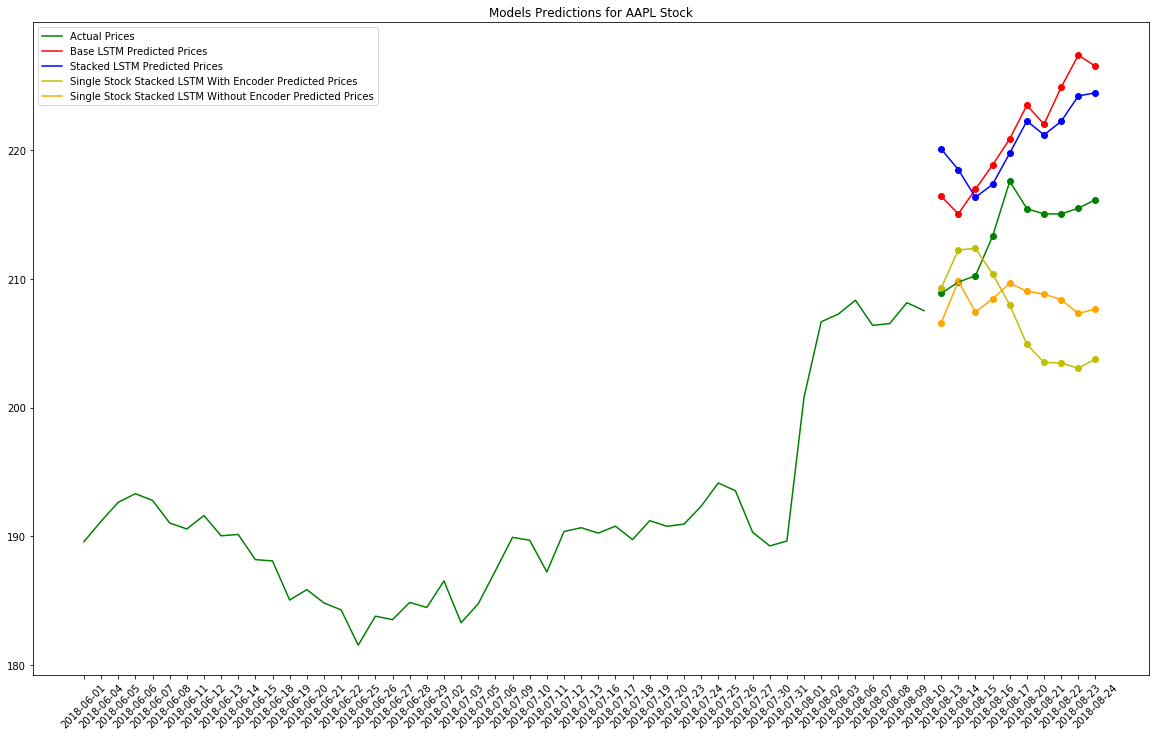

In [0]:
plt.figure(figsize=(20,12))
plt.gca().set_title("Models Predictions for {} Stock".format(stock_ticker))

plt.xticks(rotation=45)
plt.plot(train_dates[-50:], train_actual_prices.tail(50), c="g", label="Actual Prices")
plt.plot(pred_dates, val_test_actual_prices, c="g", )
plt.scatter(pred_dates, val_test_actual_prices, c="g")

plt.plot(pred_dates, base_lstm_val_test_pred_prices, c="r", label="Base LSTM Predicted Prices")
plt.scatter(pred_dates, base_lstm_val_test_pred_prices, c="r")

plt.plot(pred_dates, stacked_lstm_val_test_pred_prices, c="b", label="Stacked LSTM Predicted Prices")
plt.scatter(pred_dates, stacked_lstm_val_test_pred_prices, c="b")

plt.plot(pred_dates, single_stock_lstm_enc_val_test_pred_prices, c="y", label="Single Stock Stacked LSTM With Encoder Predicted Prices")
plt.scatter(pred_dates, single_stock_lstm_enc_val_test_pred_prices, c="y")

plt.plot(pred_dates, single_stock_lstm_val_test_pred_prices, c="orange", label="Single Stock Stacked LSTM Without Encoder Predicted Prices")
plt.scatter(pred_dates, single_stock_lstm_val_test_pred_prices, c="orange")

plt.legend()
plt.show()

We can see on the graph that deviations from the actual prices in all models are in terms of several to dozens of dollars while for the prediction to be useful the residual should be in terms of cents.

## Conclusion
***

After training autoencoder for dimentionality reduction and building embedding layer for categorical variables we optimized learning rate and trained two models with all stock tickers (2661) with total of 1,216,077 samples and another two with single stock samples with very small sample size of 457. All models need more training especially the single stock ones which opposite to my expectation perform much worse than all stock models. Single stock model with encoder perform worse than without encoder some of the reasons for this can be  undertraining or not enogh dimentions in the representational vector. The results of the best model 'stacked_lstm' are far away from useful as the error is in terms of dollars but to be applicable the residuals should be in terms of cents. As a conclusion we can say that all of the models failed and historical prices even augmented with technical indicators doesn't appear to be a good estimator of future prices.

## References
***
Etienne, B. (2019). **Time Series in Python — Exponential Smoothing and ARIMA processes**. [online] Medium. Available at: https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788


Brownlee, J. (2018). **How to Model Volatility with ARCH and GARCH for Time Series Forecasting in Python**. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/develop-arch-and-garch-models-for-time-series-forecasting-in-python/ 


Brownlee, J. (2017). **A Gentle Introduction to Autocorrelation and Partial Autocorrelation**. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/


Brownlee, J. (2016). **How to Check if Time Series Data is Stationary with Python**. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/time-series-data-stationary-python/


Brownlee, J. (2019). **3 Ways to Encode Categorical Variables for Deep Learning**. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/


Brownlee, J. (2018). **A Gentle Introduction to LSTM Autoencoders**. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/lstm-autoencoders/


Brownlee, J. (2016). **Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras**. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/


Brownlee, J. (2017). **Multivariate Time Series Forecasting with LSTMs in Keras**. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/


Brownlee, J. (2017). **Time Series Forecasting with the Long Short-Term Memory Network in Python**. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/


Cavaioni, M. (2018). **DeepLearning series: Sequence Models. [online] Medium**. Available at: https://medium.com/machine-learning-bites/deeplearning-series-sequence-models-7855babeb586


Desjardins J. (2017). **12 Types of Technical Indicators Used by Stock Traders**. [online] https://www.visualcapitalist.com/. Available at: https://www.visualcapitalist.com/12-types-technical-indicators-stocks/


Wikipedia. 2020. **Augmented_Dickey–Fuller_test**. [online] Available at: https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test. 


Hallmark, E. (2018). **Daily Historical Stock Prices (1970 - 2018)**. [online] Kaggle.com. Available at: https://www.kaggle.com/ehallmar/daily-historical-stock-prices-1970-2018#historical_stocks.csv


Stack Overflow. (2018). **Connect Encoder from AutoEncoder to LSTM**. [online] Available at: https://stackoverflow.com/questions/52201643/connect-encoder-from-autoencoder-to-lstm.

